In [1]:
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap
import h5py

from utils import *

In [2]:
# load data
df_results_all = pd.read_csv('/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/3_plots/results/results_material_properies.csv')
df_results_all.head(10)

Unnamed: 0             EMBRYO  TRACK_ID  PULSE_NUMBER MT_STATUS  AVG_FORCE  \
0           0  20240621s01p01t02         2             2         n  43.731777   
1           1  20240621s01p01t02         2             3         n  46.900588   
2           2  20240621s01p01t02         2             4         n  47.988138   
3           3  20240621s01p01t02         2             5         n  51.241256   
4           4  20240621s01p01t02         2             6         n  55.305090   
5           5  20240621s01p01t02         2             7         n  60.005093   
6           6  20240621s01p01t02         2             8         n  68.416495   
7           7  20240621s01p01t02         2             9         n  76.284062   
8           8  20240621s01p01t02         2            10         n  86.317138   
9           9  20240621s01p01t02         2            11         n  96.131588   

           k       eta_1           eta_2      k_err  ...  R_SQUARED_KV  \
0  21.266657   46.497273       28.501293   8.599834  ...      0.779351   
1  49.835248    8.671300      119.124535   2.178186  ...     -0.755094   
2  48.545614   17.507480  1000000.000000   5.582225  ...      0.241135   
3  28.920986   24.023393       83.857799   1.975636  ...      0.002447   
4  27.507318    8.101514       36.960042   2.734450  ...     -0.079466   
5  62.240904   31.915372       32.110504   9.993373  ...      0.841201   
6  22.052496  118.447174       20.964195  42.119595  ...      0.755685   
7  70.140105   43.904752      782.263367   3.028013  ...      0.046384   
8  39.570793   17.552681       38.692180   4.345725  ...      0.362772   
9  57.878093   24.160225      300.488156   2.592899  ...     -2.310617   

   fit_divisible  relax_too_much  rising_dif  relaxing_dif  rising_dif_norm  \
0           True           False    9.321315     -1.229614         0.213147   
1           True           False    2.772072      0.062041         0.059105   
2           True            True    1.178596     -0.737468         0.024560   
3           True           False    4.447798     -1.271949         0.086801   
4           True           False    8.230044     -0.528226         0.148812   
5           True           False    9.598344     -0.272391         0.159959   
6           True           False   17.145380     -0.873600         0.250603   
7           True           False    1.615231     -0.373100         0.021174   
8           True           False   11.719017     -0.699765         0.135767   
9           True           False    2.934055     -0.602346         0.030521   

   rising_dif_norm_inverse  relative_dif     tau_r         a  
0                 4.691589      0.131914  1.093197  0.206218  
1                16.918965     -0.022381  0.087000  0.346914  
2                40.716368      0.625717  0.180320  0.999782  
3                11.520589      0.285973  0.415328  0.390795  
4                 6.719902      0.064183  0.147261  0.229933  
5                 6.251609      0.028379  0.256386  0.102840  
6                 3.990375      0.050953  2.685573  0.107027  
7                47.227965      0.230989  0.312979  0.712358  
8                 7.365561      0.059712  0.221788  0.178496  
9                32.764071      0.205295  0.208716  0.535682  

[10 rows x 28 columns]

In [3]:
df_results_all = df_results_all.sort_values(by='MT_STATUS', ascending=False)
print(df_results_all.columns)

Index(['Unnamed: 0', 'EMBRYO', 'TRACK_ID', 'PULSE_NUMBER', 'MT_STATUS',
       'AVG_FORCE', 'k', 'eta_1', 'eta_2', 'k_err', 'eta_1_err', 'eta_2_err',
       'k_KV', 'eta_KV', 'k_KV_err', 'eta_KV_err', 't_1', 'R_SQUARED',
       'R_SQUARED_KV', 'fit_divisible', 'relax_too_much', 'rising_dif',
       'relaxing_dif', 'rising_dif_norm', 'rising_dif_norm_inverse',
       'relative_dif', 'tau_r', 'a'],
      dtype='object')


# General overview

In [4]:
N_tracks = len(df_results_all)
N_relaxed_too_much = len(df_results_all[df_results_all['relax_too_much'] == True])
N_not_differentiable = len(df_results_all[df_results_all['fit_divisible'] == False])

print(f'We have in total {N_tracks} tracks. ')
print(f'Out of those, we have {N_relaxed_too_much} tracks that relaxed to a value below zero. We do not take those into account.')
print(f'Furthermore, we have {N_not_differentiable} tracks that are not differentiable. We do not take those into account either.\n')

N_R_low = len(df_results_all[df_results_all['R_SQUARED'] < 0.8])
print(f'Number of fits with R^2 < 0.5: {N_R_low}')

We have in total 772 tracks. 
Out of those, we have 79 tracks that relaxed to a value below zero. We do not take those into account.
Furthermore, we have 13 tracks that are not differentiable. We do not take those into account either.

Number of fits with R^2 < 0.5: 209


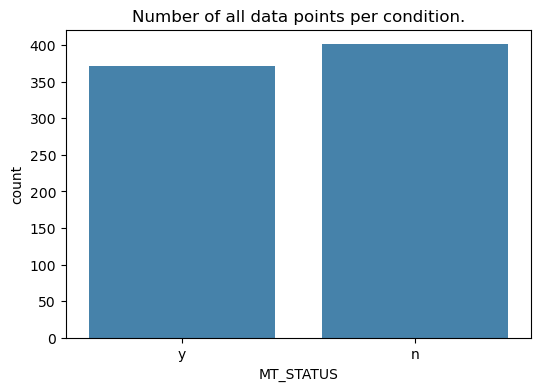

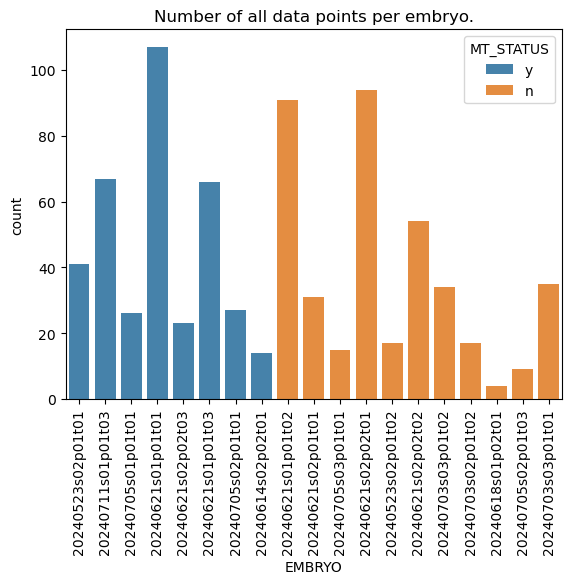

In [5]:
fig = plt.figure(figsize=(6, 4))
# Second subplot: Summary statistics

sns.countplot(data=df_results_all, x='MT_STATUS', alpha=0.9)
plt.title(f'Number of all data points per condition.')
plt.show()

sns.countplot(data=df_results_all, x='EMBRYO', hue='MT_STATUS', alpha=0.9)
plt.title(f'Number of all data points per embryo.')
plt.xticks(rotation=90)
plt.show()

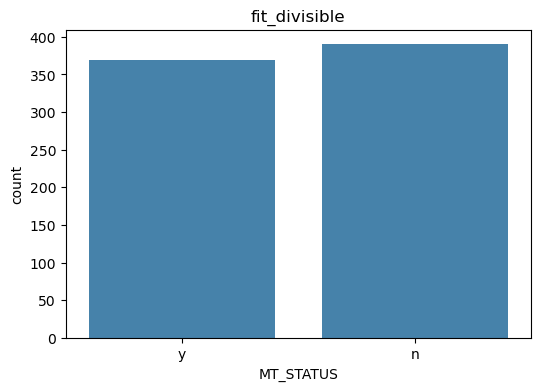

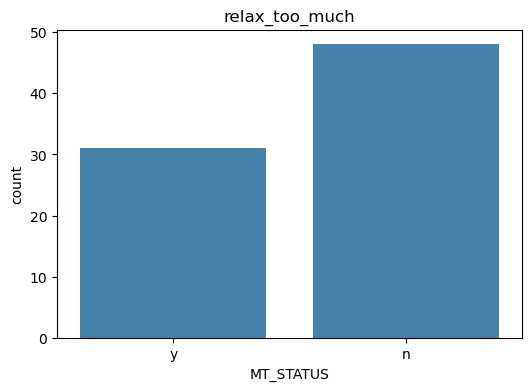

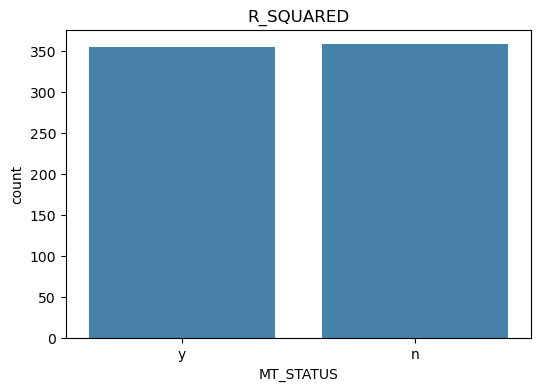

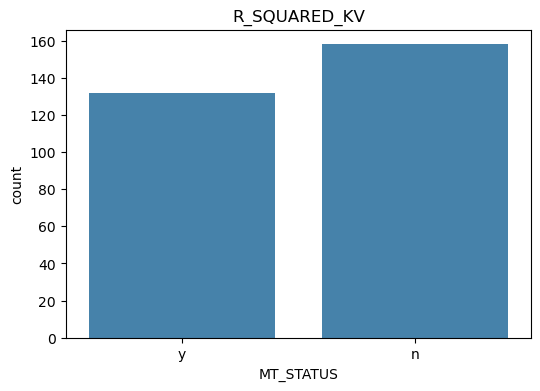

In [6]:
comparissons = ['fit_divisible', 'relax_too_much', 'R_SQUARED', 'R_SQUARED_KV']

boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)
for comp in comparissons:
    fig = plt.figure(figsize=(6, 4))
    # Second subplot: Summary statistics
    sns.countplot(data=df_results_all[df_results_all[comp]>0.5], x='MT_STATUS', alpha=0.9)
    plt.title(f'{comp}')

In [7]:
r_sq_min = 0.5
# filter out the unreasonable tracks
df_results_filtered = df_results_all[
    (df_results_all['R_SQUARED'] >= r_sq_min) &
    (df_results_all['relax_too_much'] == False) &
    (df_results_all['fit_divisible'] == True) &
    (df_results_all['k_err']/df_results_all['k'] < 1) &
    (df_results_all['eta_1_err']/df_results_all['eta_1'] < 1) &
    (df_results_all['eta_2_err']/df_results_all['eta_2'] < 1)  
]

print(f'We are left with {len(df_results_filtered)} tracks after filtering.\n')

print(f'Percentage of usable tracks in M-phase: {len(df_results_filtered[df_results_filtered["MT_STATUS"] == "n"])/len(df_results_all[df_results_all["MT_STATUS"] == "n"])*100:.2f}%')
print(f'Percentage of usable tracks in interphase: {len(df_results_filtered[df_results_filtered["MT_STATUS"] == "y"])/len(df_results_all[df_results_all["MT_STATUS"] == "y"])*100:.2f}%')

We are left with 623 tracks after filtering.

Percentage of usable tracks in M-phase: 77.81%
Percentage of usable tracks in interphase: 83.83%


In [8]:
print(f'Number of successful fits with Jeffreys model: ',  sum(df_results_all['R_SQUARED']>r_sq_min))
print(f'Number of successful fits with Kelvin Voigt model: ', sum(df_results_all['R_SQUARED_KV']>r_sq_min))
print(f'Number of better fits with KV model instead of Jeffreys: ', sum(df_results_all['R_SQUARED_KV']>df_results_all['R_SQUARED']))

print('KV fits better in M-phase: ', len(df_results_all[(df_results_all['MT_STATUS'] == 'n')&(df_results_all['R_SQUARED_KV']>df_results_all['R_SQUARED'])&((df_results_all['R_SQUARED_KV']>r_sq_min))]))
print('KV fits better in interphase: ', len(df_results_all[(df_results_all['MT_STATUS'] == 'y')&(df_results_all['R_SQUARED_KV']>df_results_all['R_SQUARED'])&((df_results_all['R_SQUARED_KV']>r_sq_min))]))

Number of successful fits with Jeffreys model:  713
Number of successful fits with Kelvin Voigt model:  290
Number of better fits with KV model instead of Jeffreys:  108
KV fits better in M-phase:  36
KV fits better in interphase:  34


# The data that is still left after filtering 

We removed:
- the data with poor fits (R^2 lower than 0.5)
- the fits with very high errors for parameters
- the data that relaxes below 0 (this indicates some reorganization of the cytoplasm beyond the responce to the magnetic pulse)
- the data with practically non-differentiable fits (those would be "good" fits but not compatible with our physical model of the cytoplasm)


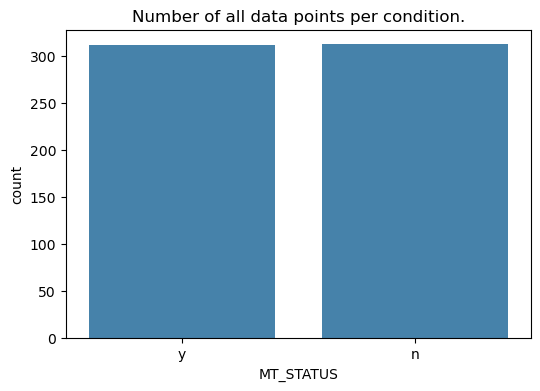

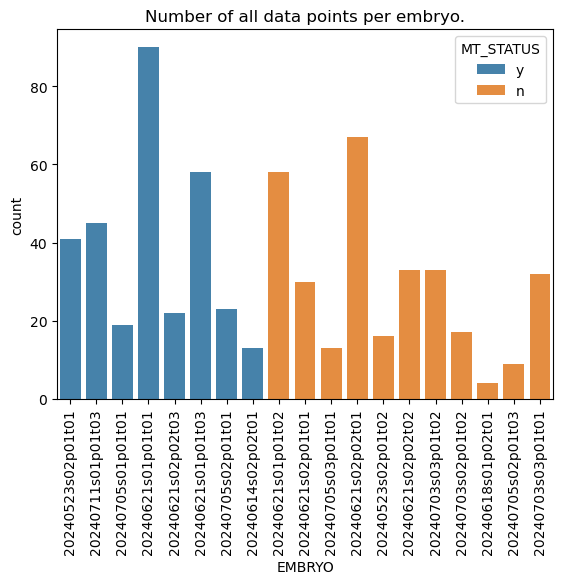

In [9]:
fig = plt.figure(figsize=(6, 4))
# Second subplot: Summary statistics

sns.countplot(data=df_results_filtered, x='MT_STATUS', alpha=0.9)
plt.title(f'Number of all data points per condition.')
plt.show()

sns.countplot(data=df_results_filtered, x='EMBRYO', hue='MT_STATUS', alpha=0.9)
plt.title(f'Number of all data points per embryo.')
plt.xticks(rotation=90)
plt.show()

# All data groupped together

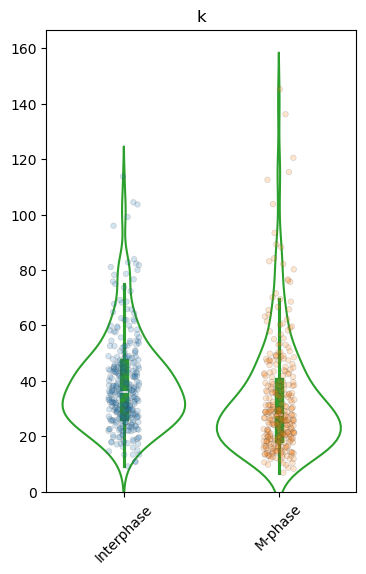

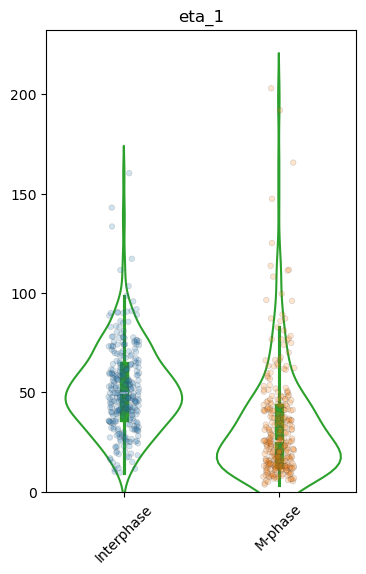

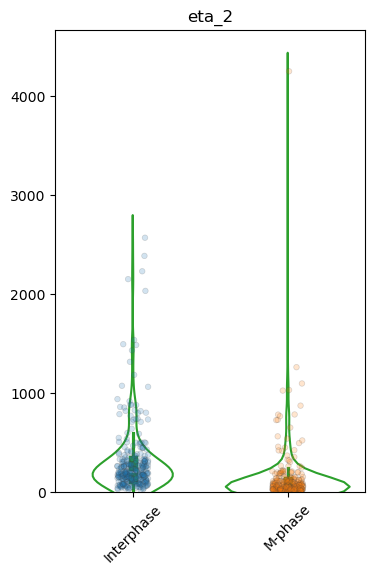

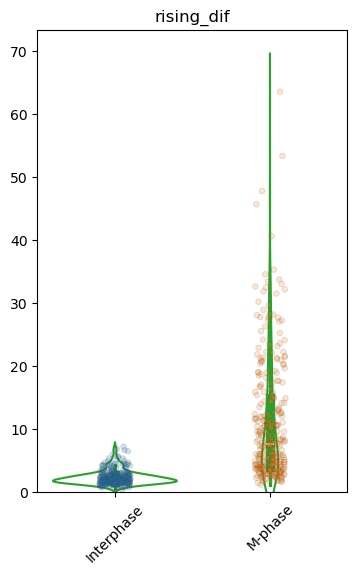

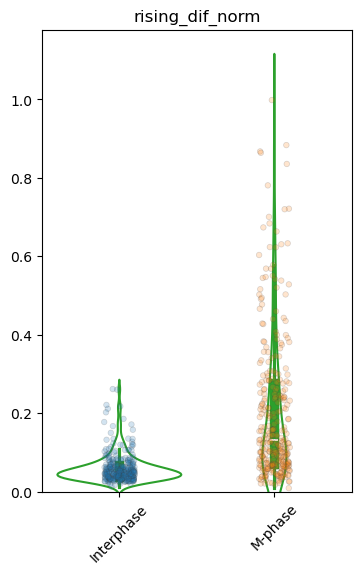

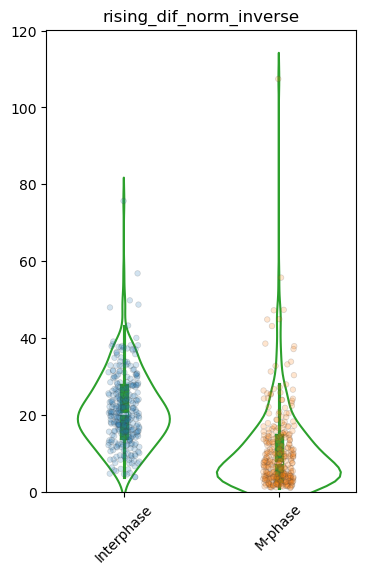

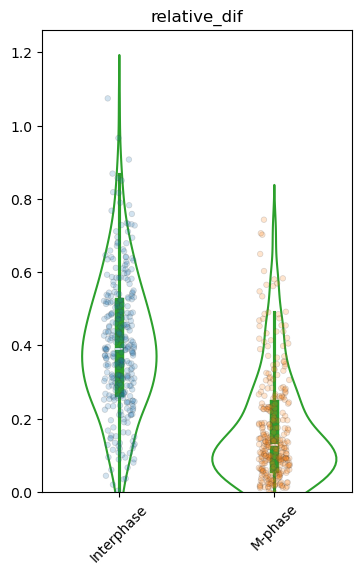

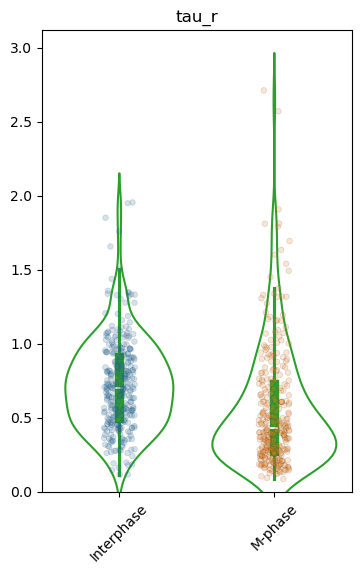

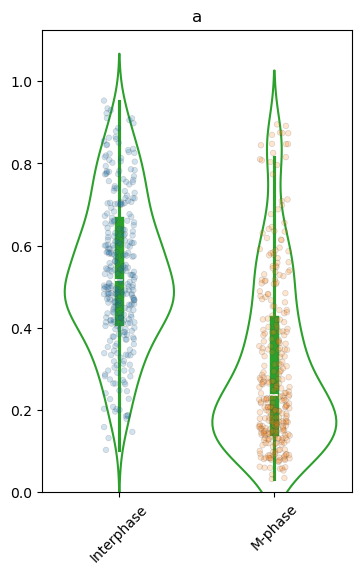

In [10]:
params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'rising_dif_norm', 'rising_dif_norm_inverse',
       'relative_dif', 'tau_r', 'a']

boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)
for param in params:
    fig = plt.figure(figsize=(4, 6))
    # sns.boxplot(x='MT_STATUS', y=param, data=df_results_filtered, boxprops=boxprops, fliersize=0)
    sns.stripplot(x='MT_STATUS', y=param, hue='MT_STATUS', data=df_results_filtered, jitter=True, alpha=0.2, linewidth=0.5, legend=False, size=4)
    sns.violinplot(x='MT_STATUS', y=param, data=df_results_filtered, fill=False)
    plt.title(f'{param}')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks = ['y', 'n'], labels=['Interphase', 'M-phase'], rotation=45)
    plt.ylim(bottom=0)
    plt.show()


# Clustered data

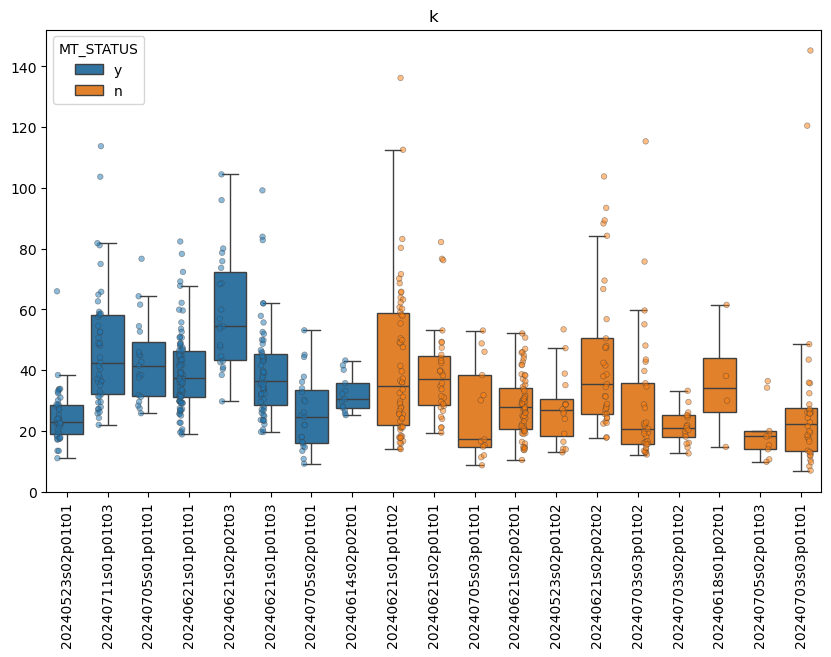

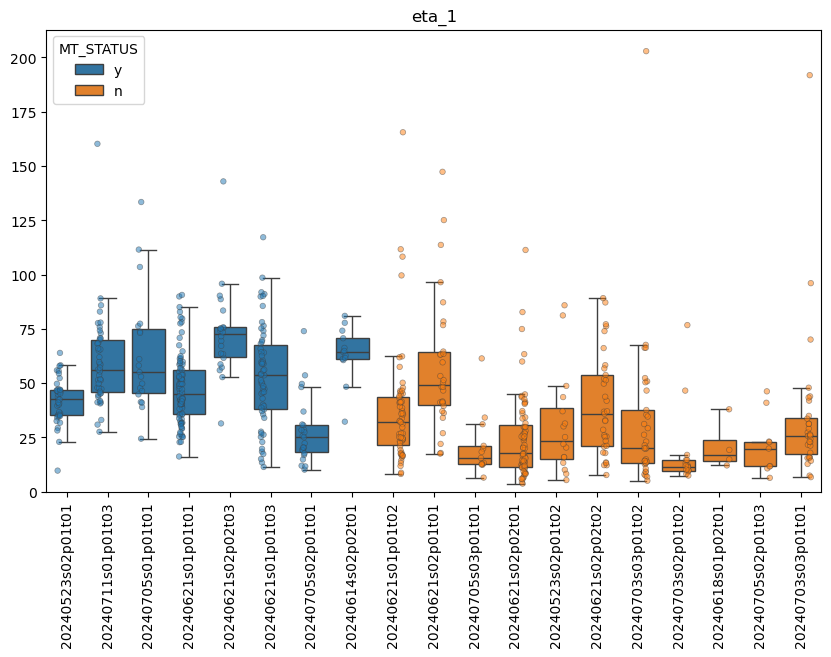

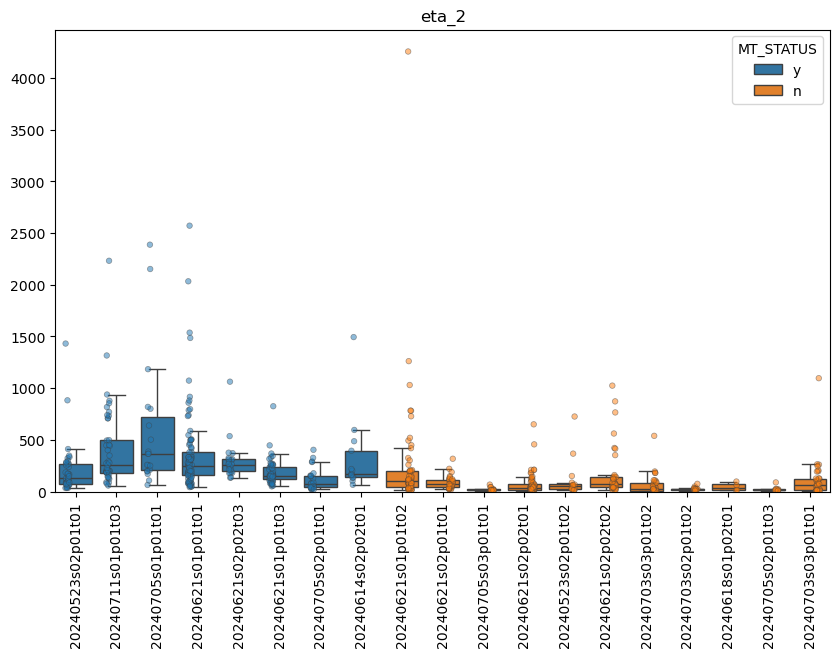

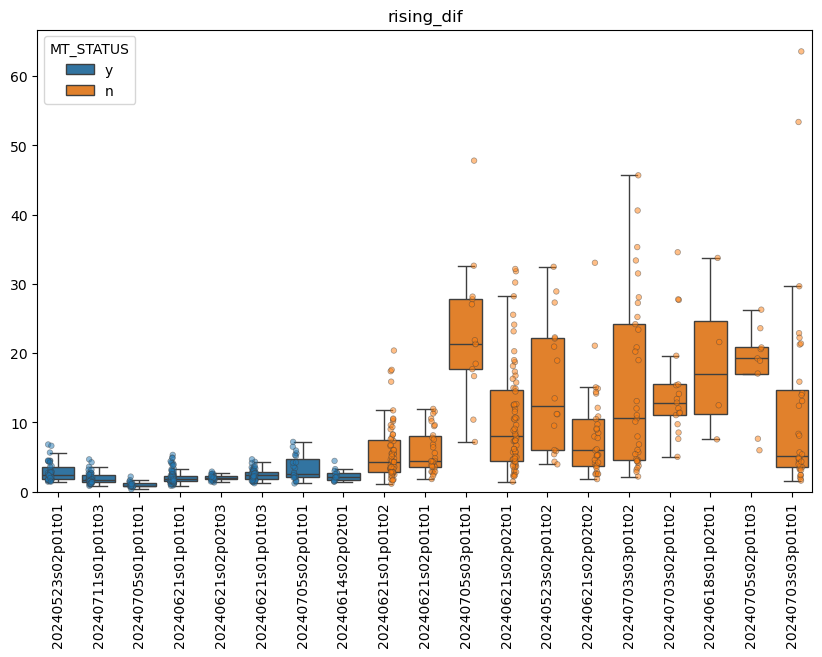

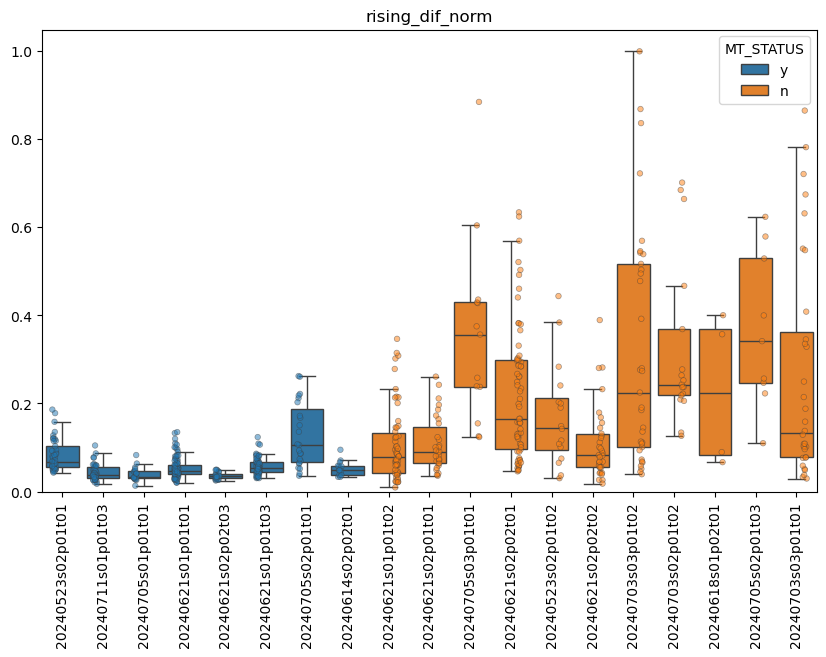

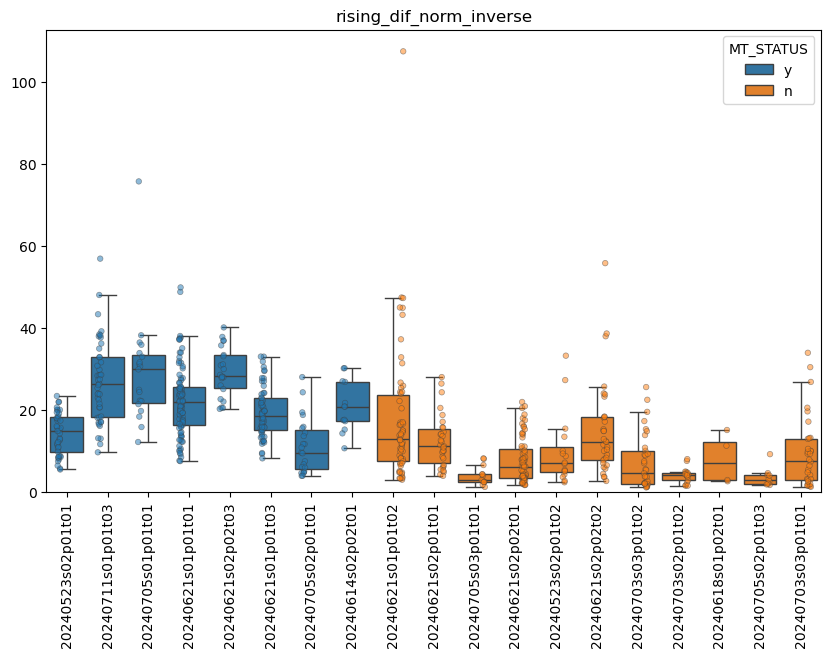

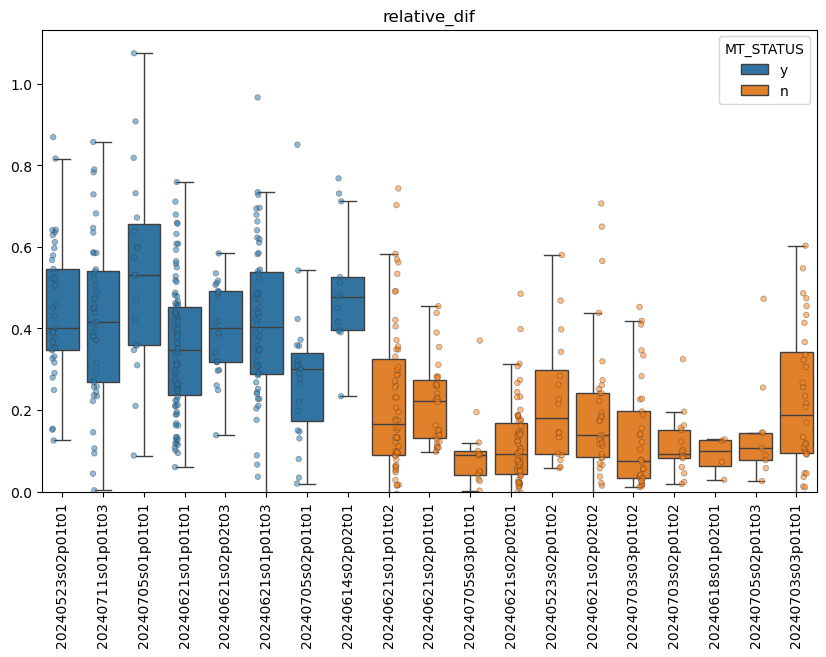

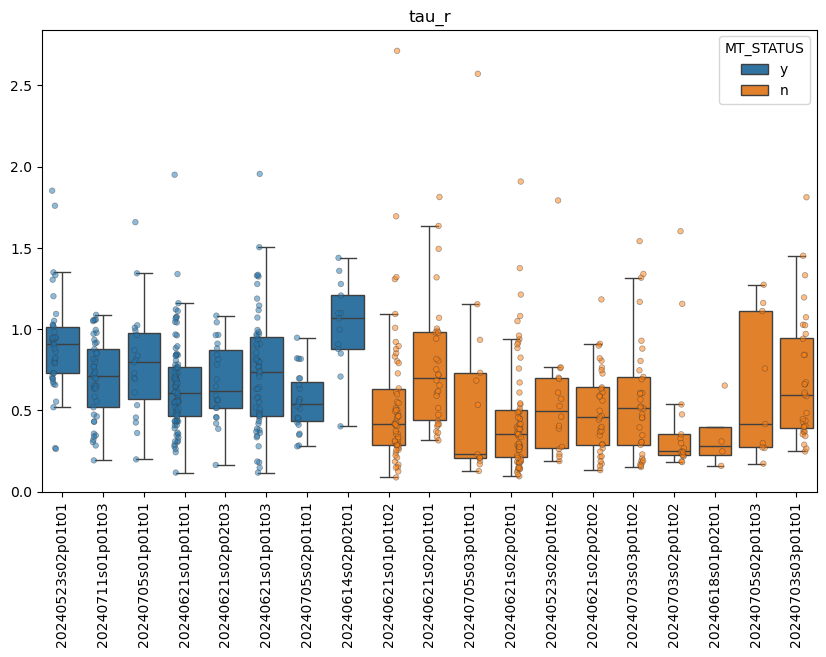

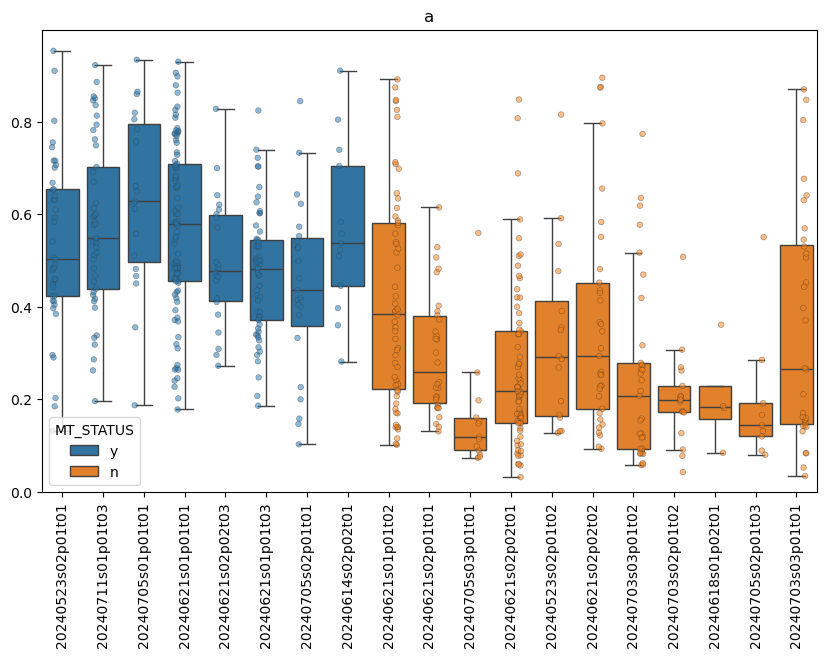

In [11]:
params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'rising_dif_norm', 'rising_dif_norm_inverse',
       'relative_dif', 'tau_r', 'a']

boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)

for param in params:
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='EMBRYO', y=param, hue='MT_STATUS', data=df_results_filtered, fliersize=0)
    sns.stripplot(x='EMBRYO', y=param, hue='MT_STATUS', data=df_results_filtered, dodge=True, jitter=True, alpha=0.5, linewidth=0.5, legend=False, size=4)
    # sns.violinplot(x='EMBRYO', y=param, hue='MT_STATUS', data=df_results_filtered, fill=False)
    plt.title(f'{param}')
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(bottom=0)
    plt.xticks(rotation=90)
    plt.show()

# Binned by the pulse number

There seems to be no significant trend in the measurements from repetitive pulses. Although, there is a slight change from teh first pulse to the rest. 

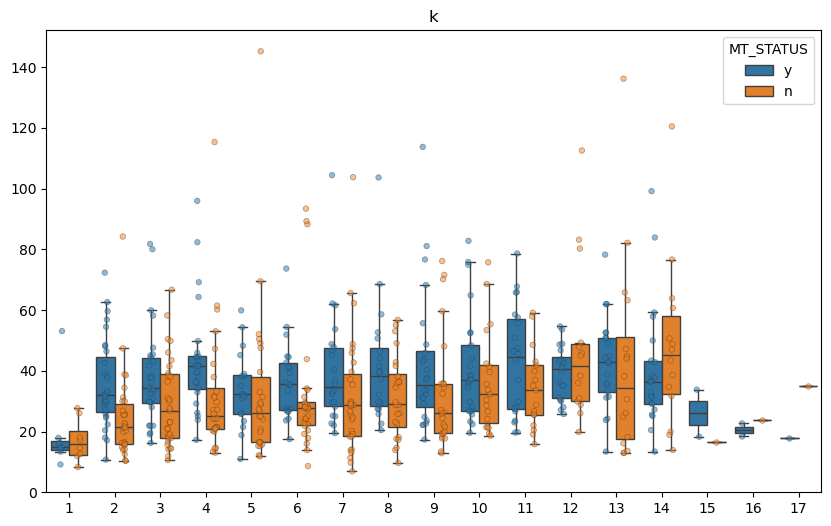

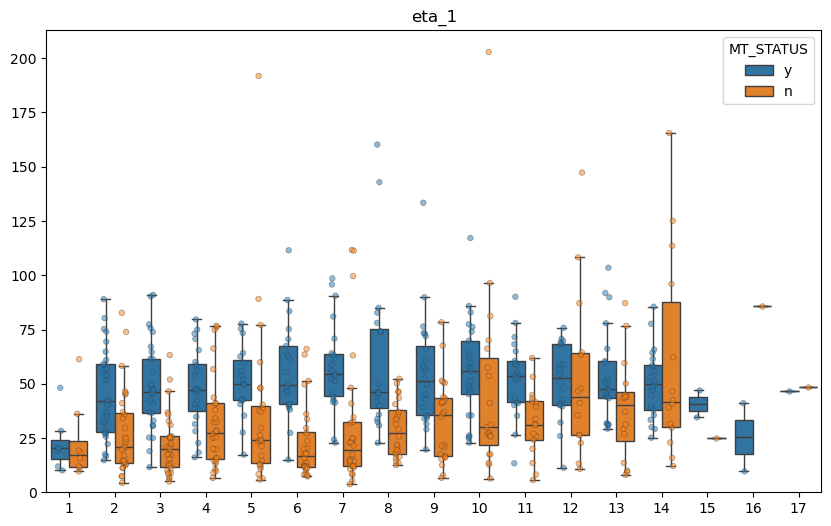

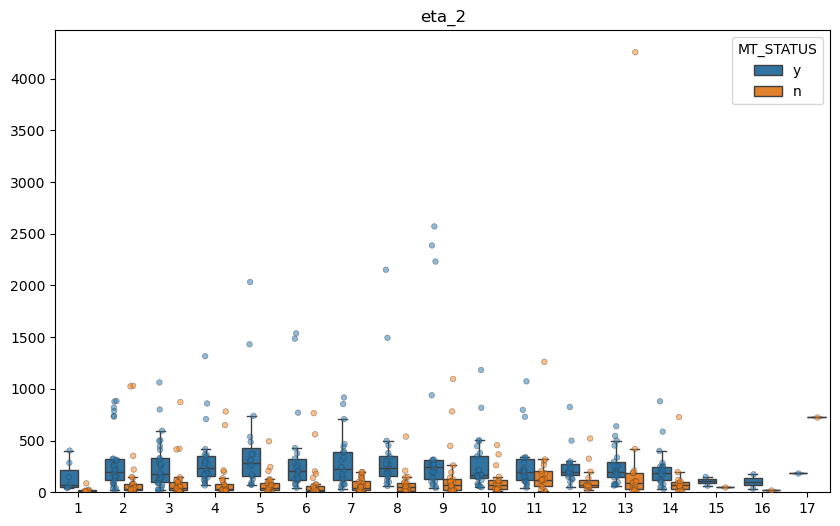

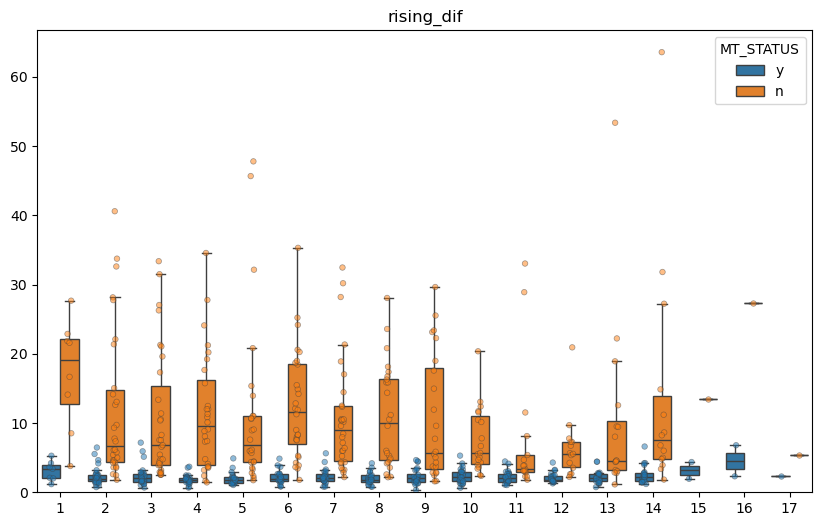

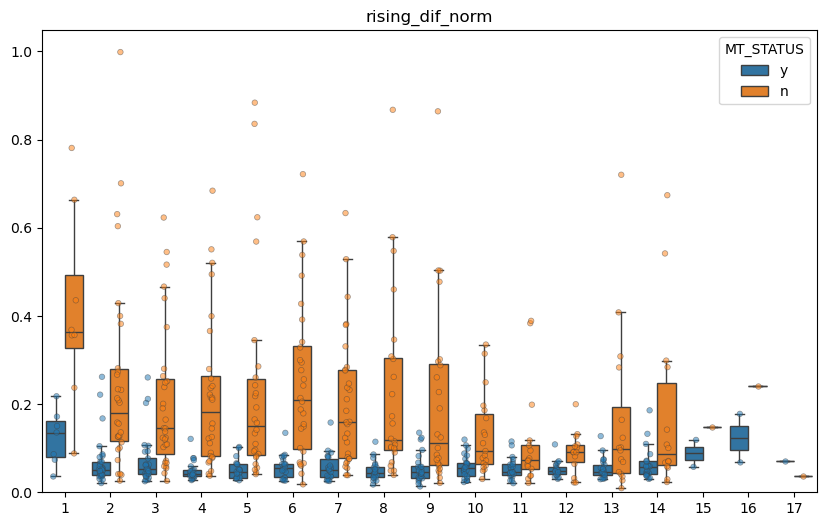

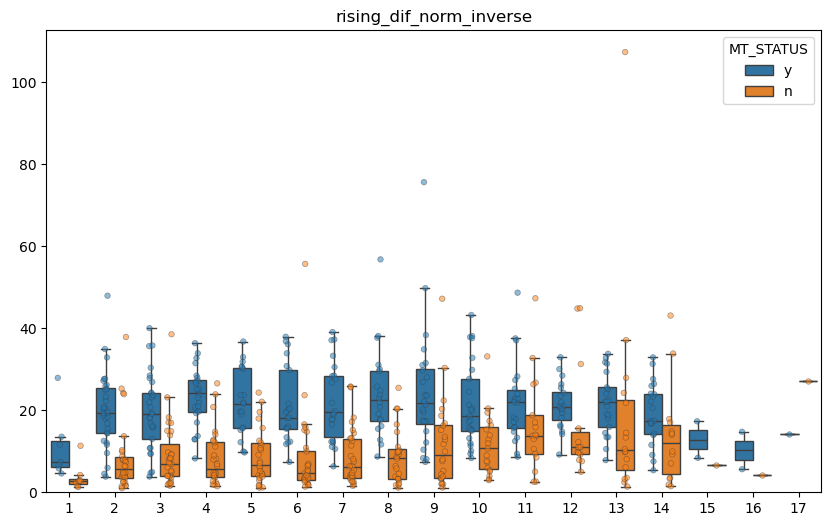

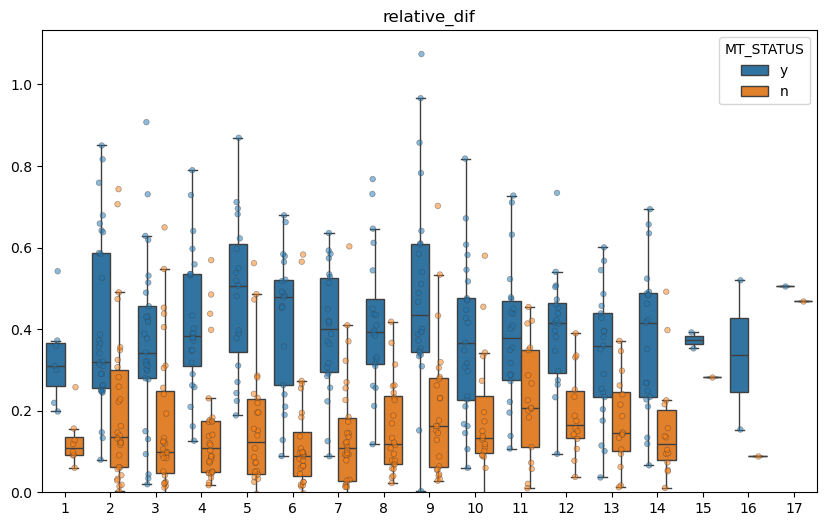

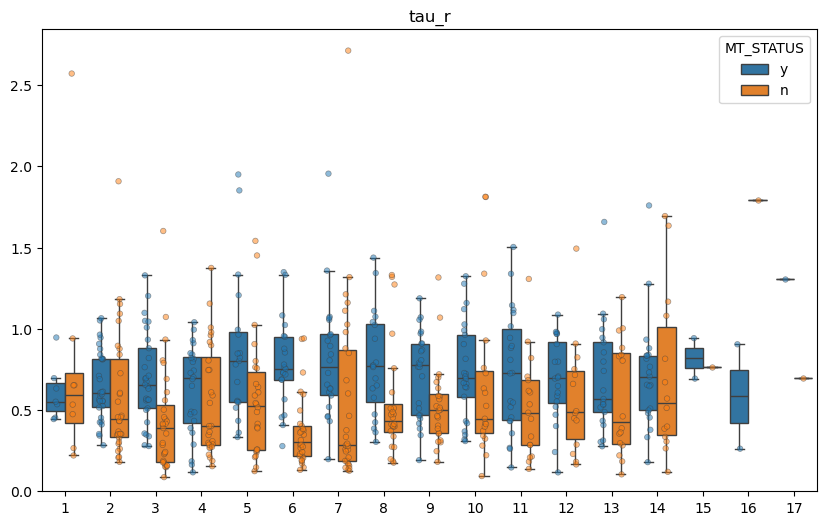

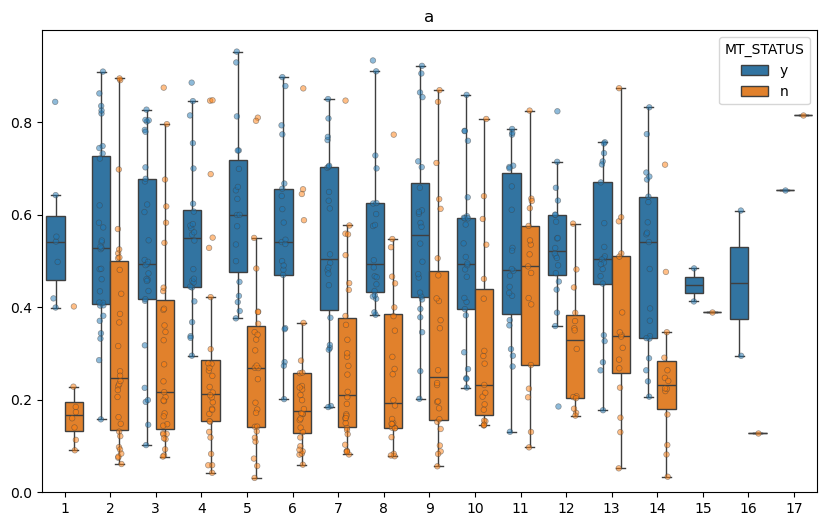

In [12]:
params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'rising_dif_norm', 'rising_dif_norm_inverse',
       'relative_dif', 'tau_r', 'a']

boxprops = dict(linestyle='-', linewidth=1, color='gray', fill=False)
for param in params:
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='PULSE_NUMBER', y=param, hue='MT_STATUS', data=df_results_filtered, fliersize=0)
    sns.stripplot(x='PULSE_NUMBER', y=param, hue='MT_STATUS', data=df_results_filtered, dodge=True, jitter=True, alpha=0.5, linewidth=0.5, legend=False, size=4)
    # sns.violinplot(x='EMBRYO', y=param, hue='MT_STATUS', data=df_results_filtered, fill=False)
    plt.title(f'{param}')
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(bottom=0)

    plt.show()

# Binned by force

## Data together with rolling average

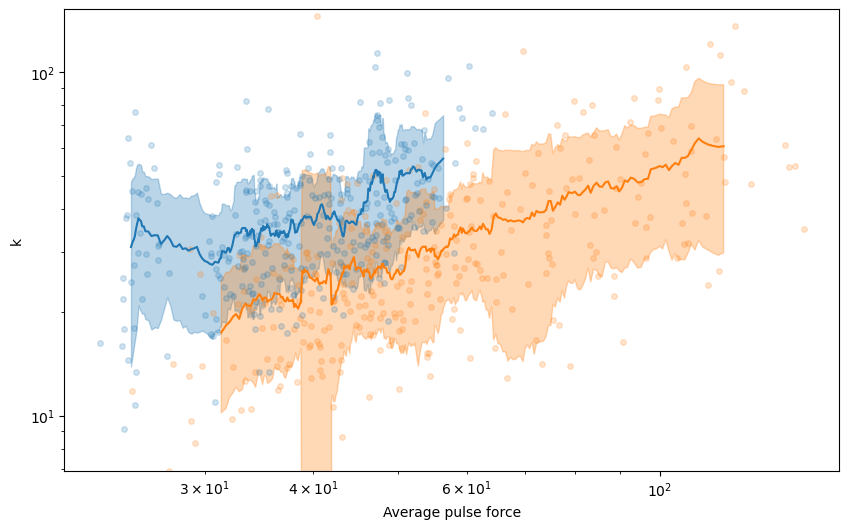

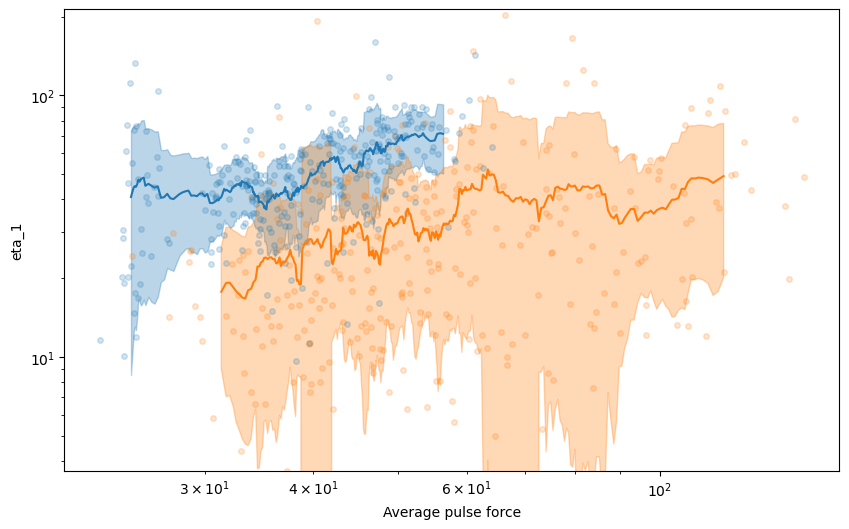

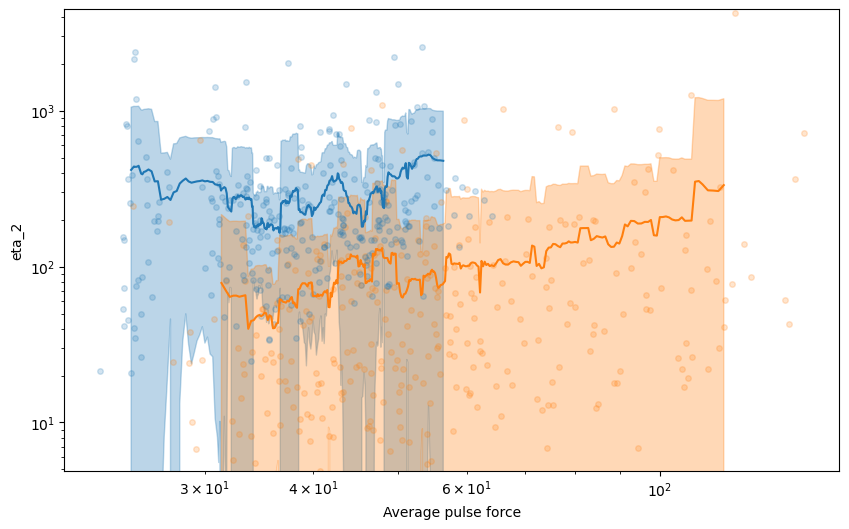

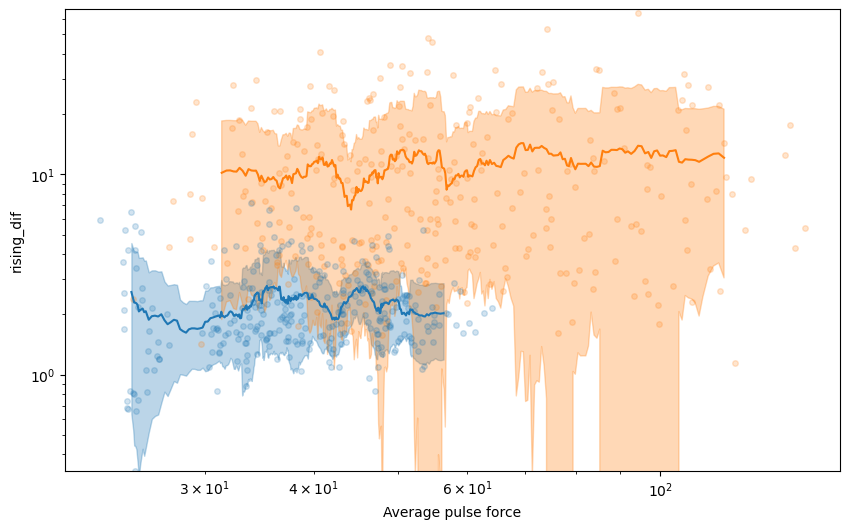

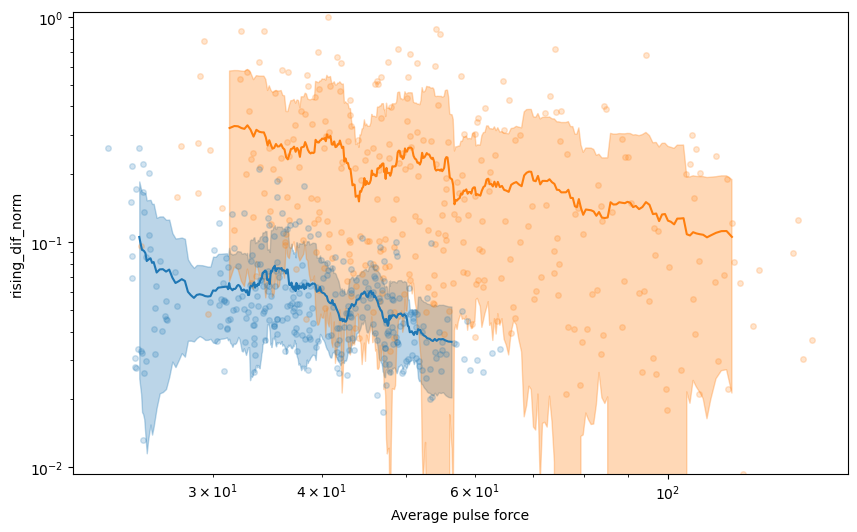

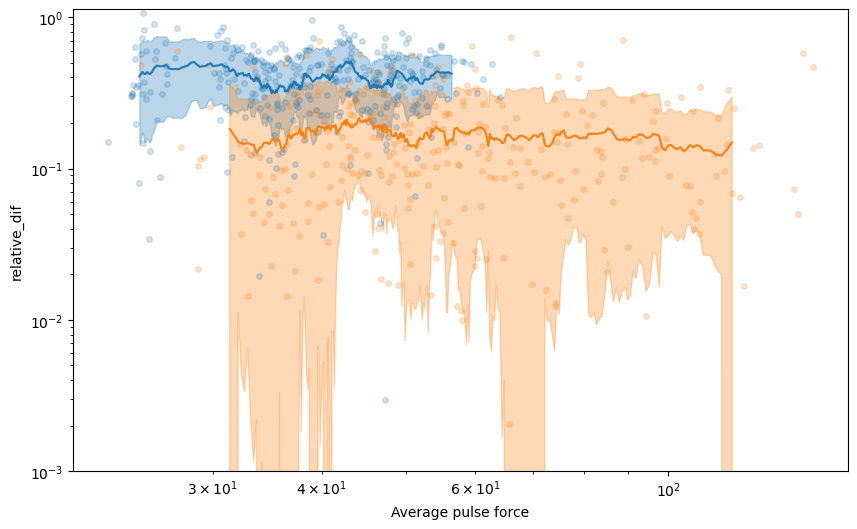

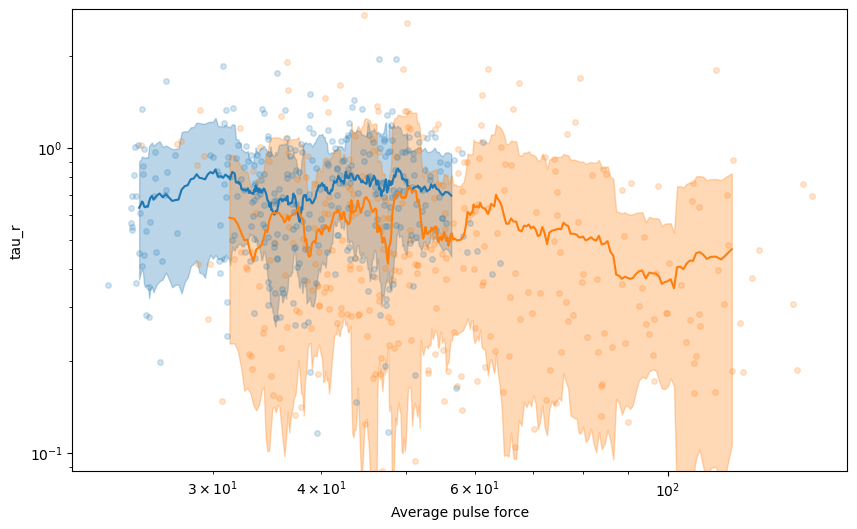

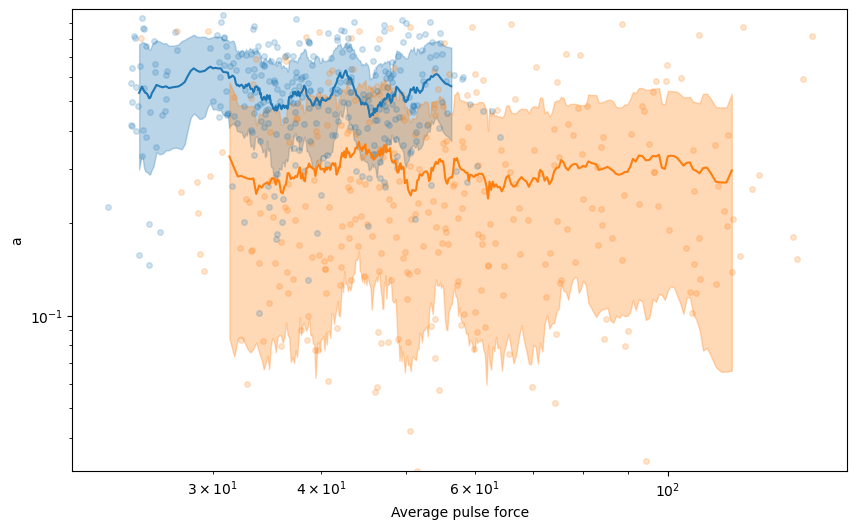

In [13]:
params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'rising_dif_norm',
       'relative_dif', 'tau_r', 'a']

df_results_filtered = df_results_filtered.sort_values(by='AVG_FORCE', ascending=True)

for param in params:
    fig = plt.figure(figsize=(10, 6))
    # plot all data
    plt.plot(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', 'AVG_FORCE'], df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param], 'o', color=sns.color_palette()[1], alpha=0.2, markersize = 4)
    plt.plot(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', 'AVG_FORCE'], df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param], 'o', color=sns.color_palette()[0], alpha=0.2, markersize = 4)
    
    window = 25
    # plot the roling average
    plt.plot(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', 'AVG_FORCE'].rolling(window=window, center=True).mean(), df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param].rolling(window=window, center=True).mean(), '-', color=sns.color_palette()[0], alpha=1)

    plt.plot(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', 'AVG_FORCE'].rolling(window=window, center=True).mean(), df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param].rolling(window=window , center=True).mean(), '-', color=sns.color_palette()[1], alpha=1)

    # plot the standard deviation
    plt.fill_between(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', 'AVG_FORCE'].rolling(window=window, center=True).mean(), 
    df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param].rolling(window=window, center=True).mean()- df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param].rolling(window=window, center=True).std(), 
    df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param].rolling(window=window, center=True).mean()+ df_results_filtered.loc[df_results_filtered['MT_STATUS']=='y', param].rolling(window=window, center=True).std(),
    color=sns.color_palette()[0], alpha=0.3)

    plt.fill_between(df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', 'AVG_FORCE'].rolling(window=window, center=True).mean(), 
    df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param].rolling(window=window, center=True).mean()- df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param].rolling(window=window, center=True).std(), 
    df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param].rolling(window=window, center=True).mean()+ df_results_filtered.loc[df_results_filtered['MT_STATUS']=='n', param].rolling(window=window, center=True).std(),
    color=sns.color_palette()[1], alpha=0.3)


    plt.xlabel('Average pulse force')
    plt.ylabel(param)
    plt.ylim(bottom=max(df_results_filtered[param].min(), 0.001))
    # plt.xlim(left=0)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

## Bootstrapping the data

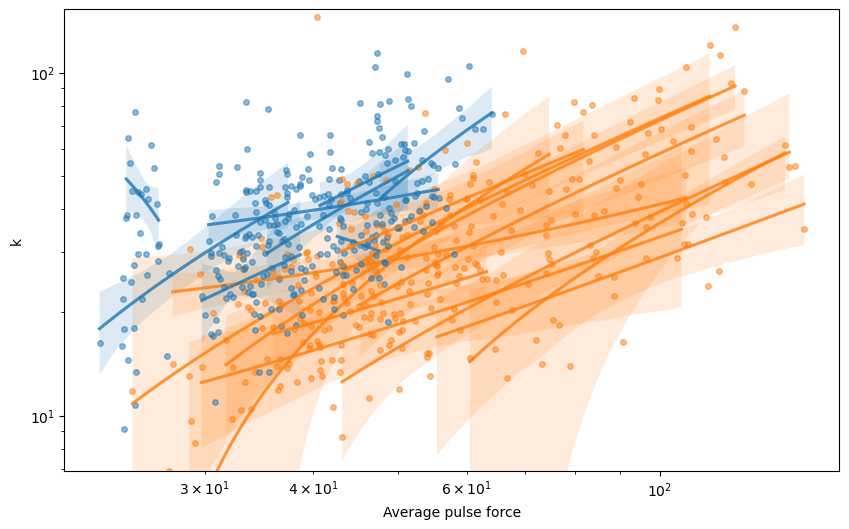

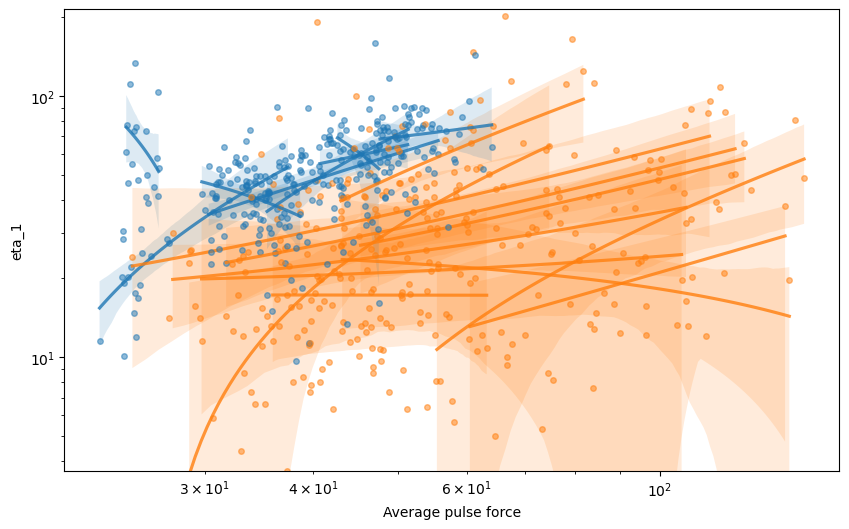

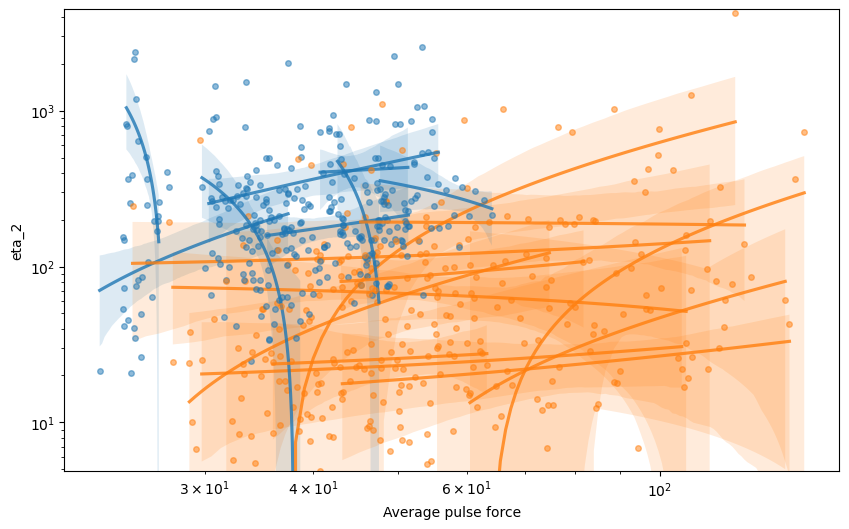

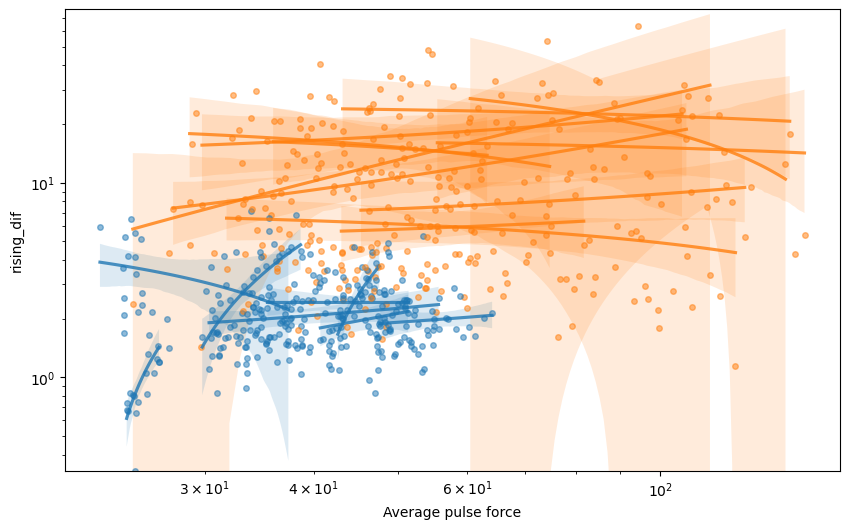

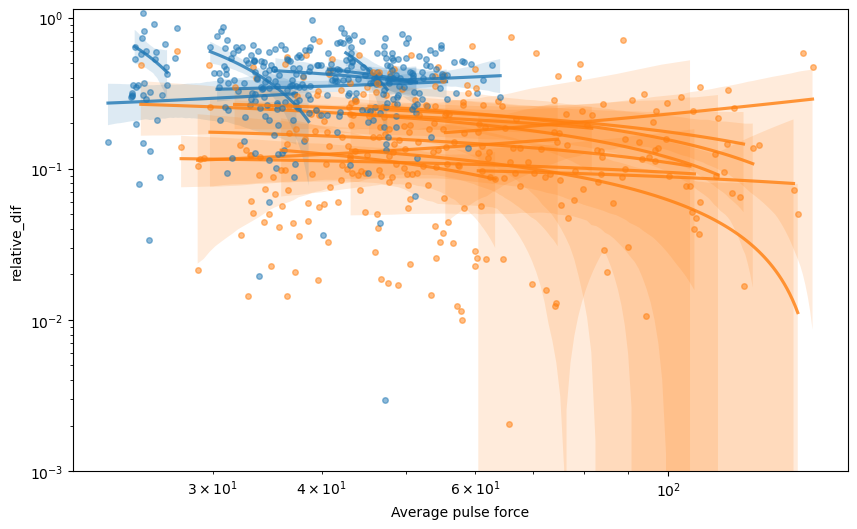

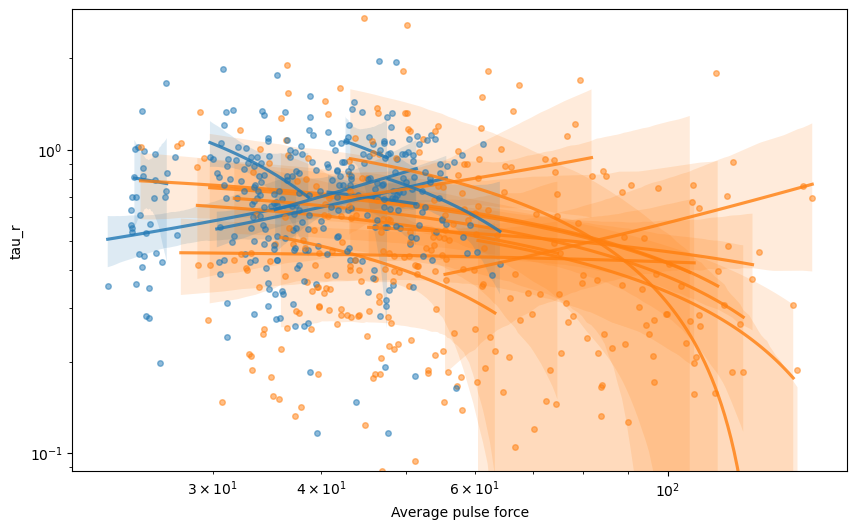

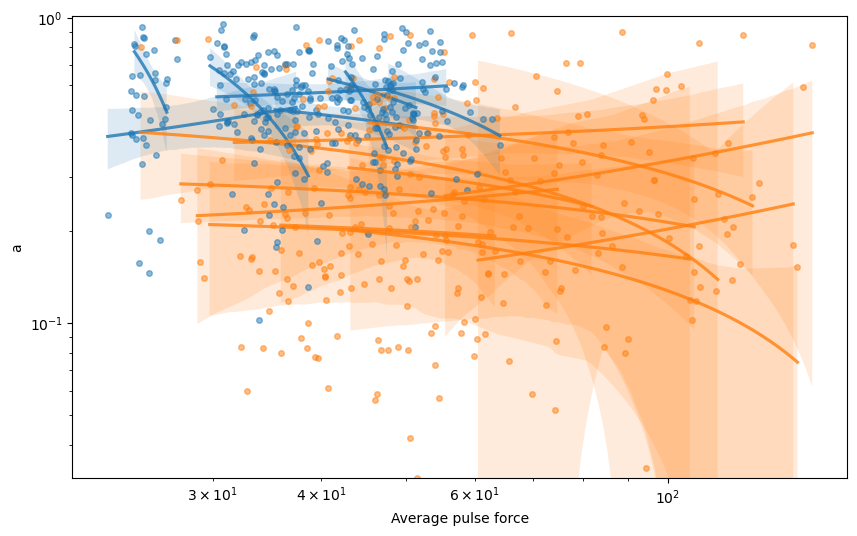

In [14]:
rng = np.random.default_rng()

params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'relative_dif', 'tau_r', 'a']

df_results_filtered = df_results_filtered.sort_values(by='AVG_FORCE', ascending=True)

for param in params:
    fig = plt.figure(figsize=(10, 6))
    # plot all data
    for (i, embryo) in enumerate(df_results_filtered['EMBRYO'].unique()):
        plt.plot(df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='n')&(df_results_filtered['EMBRYO']==embryo), 'AVG_FORCE'], df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='n')&(df_results_filtered['EMBRYO']==embryo), param], 'o', color=sns.color_palette()[1], alpha=0.5, markersize = 4, label=embryo)
        plt.plot(df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='y')&(df_results_filtered['EMBRYO']==embryo), 'AVG_FORCE'], df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='y')&(df_results_filtered['EMBRYO']==embryo), param], 'o', color=sns.color_palette()[0], alpha=0.5, markersize = 4, label=embryo)
        
        if len(df_results_filtered[(df_results_filtered['MT_STATUS']=='y')&(df_results_filtered['EMBRYO']==embryo)].dropna()) > 0:
            sns.regplot(data=df_results_filtered[(df_results_filtered['MT_STATUS']=='y')&(df_results_filtered['EMBRYO']==embryo)], x='AVG_FORCE', y=param, ci=95, robust=False, marker='', line_kws=dict(color=sns.color_palette()[0], alpha=0.8))

        if len(df_results_filtered[(df_results_filtered['MT_STATUS']=='n')&(df_results_filtered['EMBRYO']==embryo)].dropna()) > 0:
            sns.regplot(data=df_results_filtered[(df_results_filtered['MT_STATUS']=='n')&(df_results_filtered['EMBRYO']==embryo)], x='AVG_FORCE', y=param, ci=95, robust=False, marker='', line_kws=dict(color=sns.color_palette()[1], alpha=0.8))
    
    plt.xlabel('Average pulse force')
    plt.ylabel(param)
    # plt.legend()
    plt.ylim(bottom=max(df_results_filtered[param].min(), 0.001))
    # plt.xlim(left=0)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

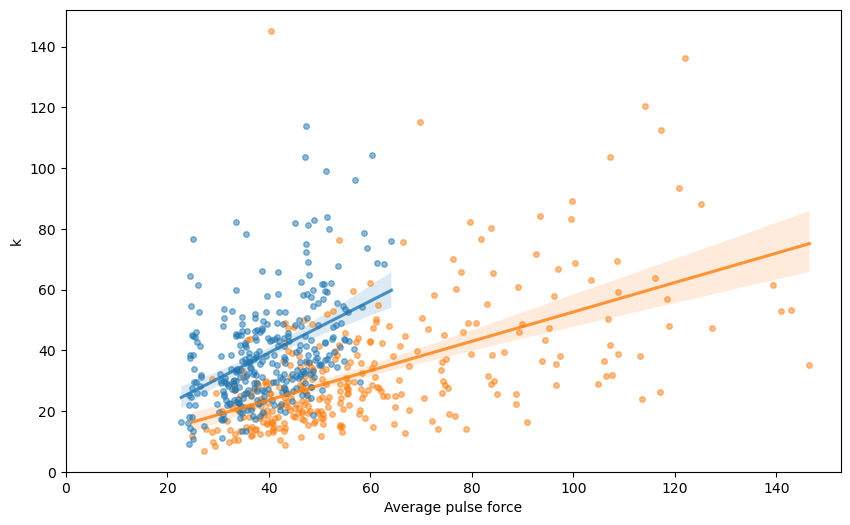

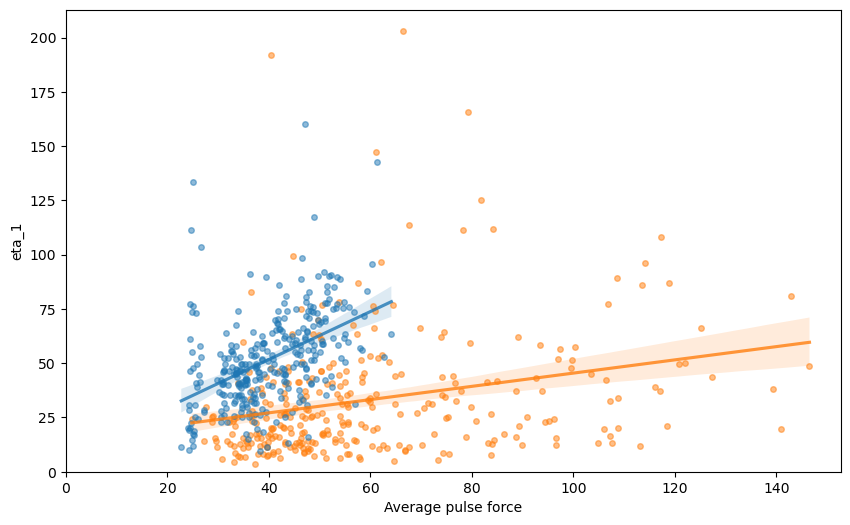

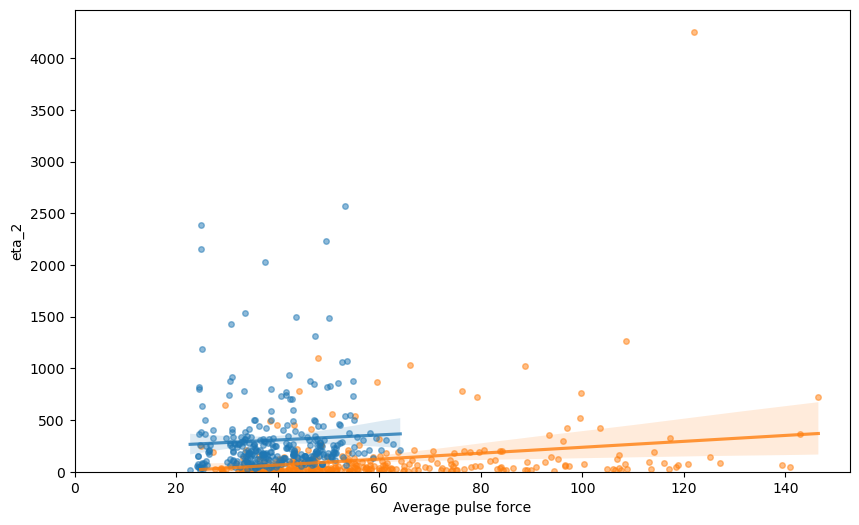

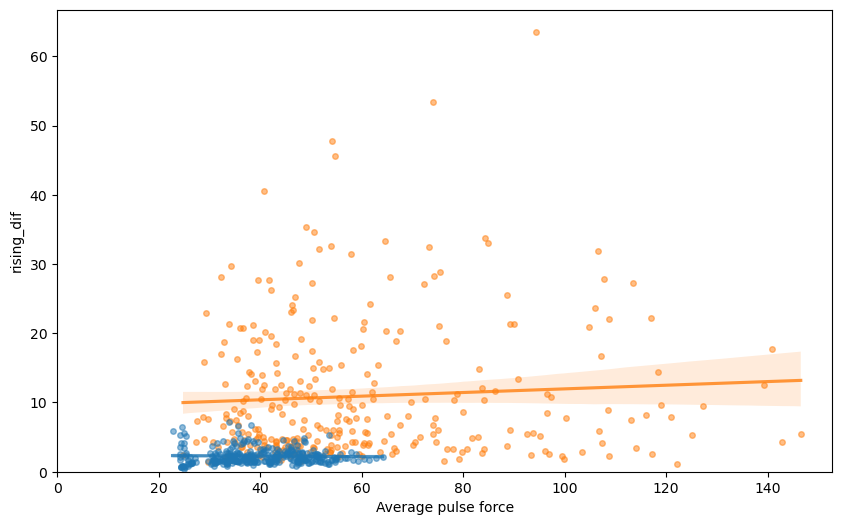

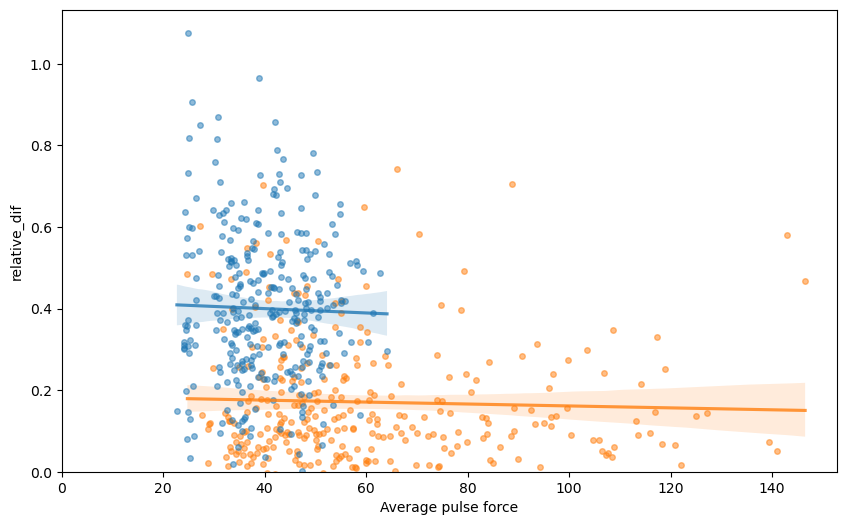

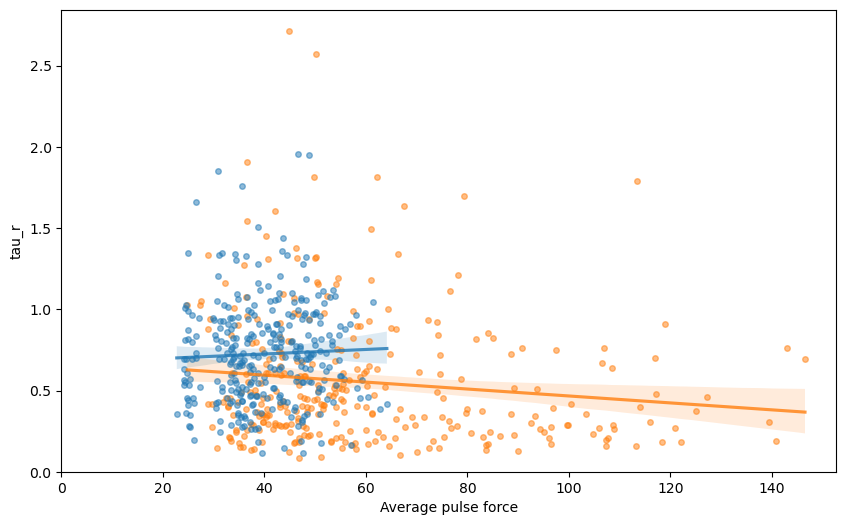

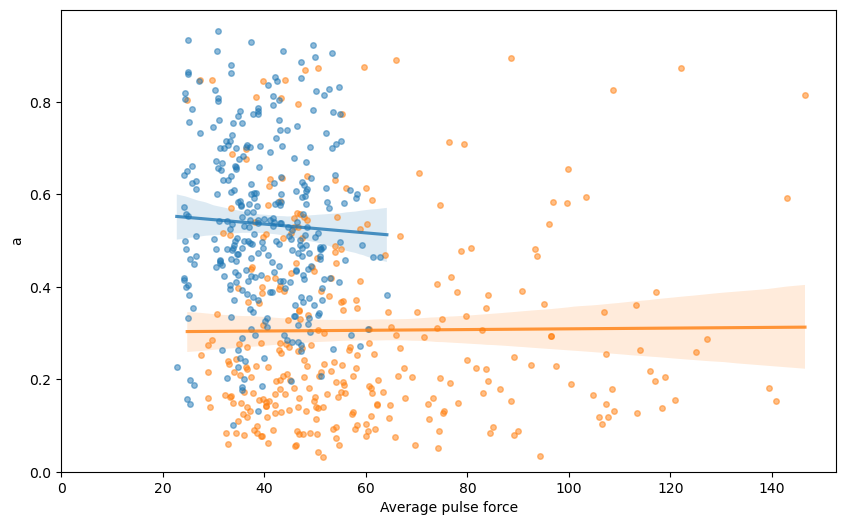

In [15]:
params = ['k', 'eta_1', 'eta_2', 'rising_dif', 'relative_dif', 'tau_r', 'a']

df_results_filtered = df_results_filtered.sort_values(by='AVG_FORCE', ascending=True)

for param in params:
    fig = plt.figure(figsize=(10, 6))
    # plot all data
    plt.plot(df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='n'), 'AVG_FORCE'], df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='n'), param], 'o', color=sns.color_palette()[1], alpha=0.5, markersize = 4, label=embryo)
    plt.plot(df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='y'), 'AVG_FORCE'], df_results_filtered.loc[(df_results_filtered['MT_STATUS']=='y'), param], 'o', color=sns.color_palette()[0], alpha=0.5, markersize = 4, label=embryo)
    
    sns.regplot(data=df_results_filtered[(df_results_filtered['MT_STATUS']=='y')], x='AVG_FORCE', y=param, ci=95, robust=False, marker='', line_kws=dict(color=sns.color_palette()[0], alpha=0.8))

    sns.regplot(data=df_results_filtered[(df_results_filtered['MT_STATUS']=='n')], x='AVG_FORCE', y=param, ci=95, robust=False, marker='', line_kws=dict(color=sns.color_palette()[1], alpha=0.8))
    
    plt.xlabel('Average pulse force')
    plt.ylabel(param)
    # plt.legend()
    plt.ylim(bottom=max(df_results_filtered[param].min(), 0.001))
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()

# Individual curves averaged and binned by force

In [16]:
folder = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/'

df_all_tracks = pd.DataFrame()
for file in os.listdir(folder):
    if file.endswith('.h5'):
        # Read the data using pandas
        df = pd.read_hdf(folder+file)
        df['file'] = file
        df['EMBRYO'] = file[:18].replace('_', '')
        df_all_tracks = pd.concat([df_all_tracks, df])

df_all_tracks.dropna(subset=['CORRECTED DISPLACEMENT [um]'], inplace=True)

print(df_all_tracks.columns)

Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_CH1', 'MEDIAN_INTENSITY_CH1',
       'MIN_INTENSITY_CH1', 'MAX_INTENSITY_CH1', 'TOTAL_INTENSITY_CH1',
       'STD_INTENSITY_CH1', 'CONTRAST_CH1', 'SNR_CH1', 'DISTANCE [um]',
       'MAGNET_STATUS', 'PULSE_NUMBER', 'FORCE [pN]', 'MT_STATUS',
       'DISPLACEMENT [um]', 'CORRECTION_k', 'CORRECTION_k_ERR', 'CORRECTION_N',
       'CORRECTION_N_ERR', 'CORRECTED DISPLACEMENT [um]', 'file', 'EMBRYO'],
      dtype='object')


In [17]:
df_all_tracks['USABLE'] = np.zeros(len(df_all_tracks))
for measurement in df_results_filtered[['EMBRYO', 'TRACK_ID', 'PULSE_NUMBER']].values:
    embryo, track, pulse = measurement
    
    df = df_all_tracks.loc[(df_all_tracks['EMBRYO']==embryo)&(df_all_tracks['TRACK_ID']==track)&(df_all_tracks['PULSE_NUMBER']==pulse)]

    df_all_tracks.loc[(df_all_tracks['EMBRYO']==embryo)&(df_all_tracks['TRACK_ID']==track)&(df_all_tracks['PULSE_NUMBER']==pulse), 'NORMALIZED_TIME'] = df['POSITION_T']-np.min(df['POSITION_T'])
    
    df_all_tracks.loc[(df_all_tracks['EMBRYO']==embryo)&(df_all_tracks['TRACK_ID']==track)&(df_all_tracks['PULSE_NUMBER']==pulse), 'AVG_FORCE'] = df_results_filtered.loc[(df_results_filtered['EMBRYO']==embryo)&(df_results_filtered['TRACK_ID']==track)&(df_results_filtered['PULSE_NUMBER']==pulse), 'AVG_FORCE'].values[0]

    df_all_tracks.loc[(df_all_tracks['EMBRYO']==embryo)&(df_all_tracks['TRACK_ID']==track)&(df_all_tracks['PULSE_NUMBER']==pulse), 'USABLE'] = 1

    if len(df['POSITION_T'])>50:
        plt.plot(df['POSITION_T']-np.min(df['POSITION_T']), df['CORRECTED DISPLACEMENT [um]'], 'o', color=sns.color_palette()[0], alpha=0.5, markersize = 4)
        plt.show()
        print(embryo, track, pulse) 

print(len(df_all_tracks[df_all_tracks['USABLE'] == 1])/len(df_all_tracks))

0.8079693685508469


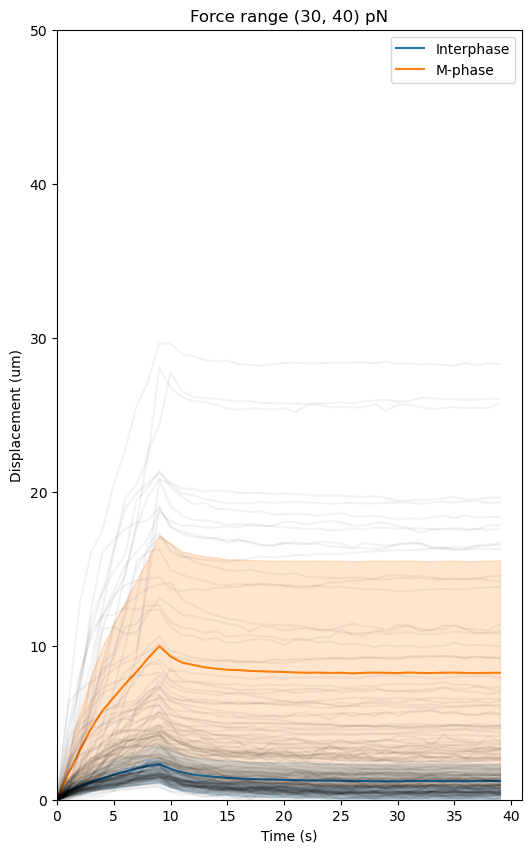

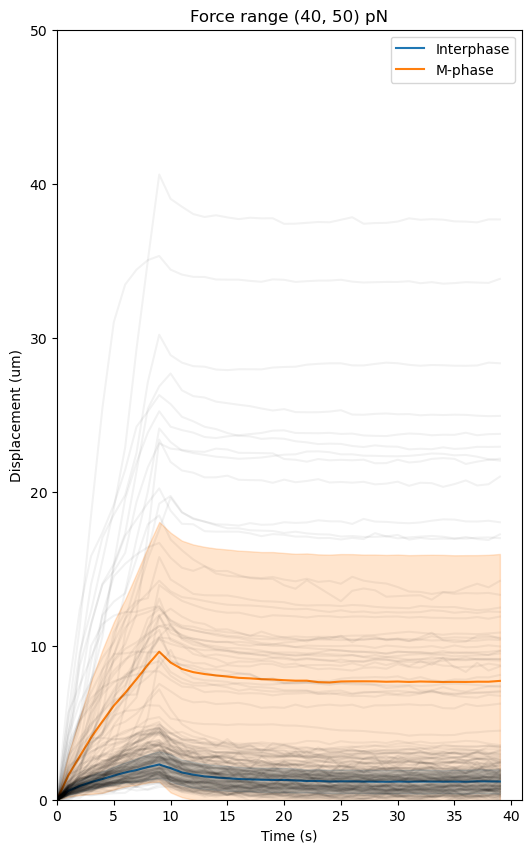

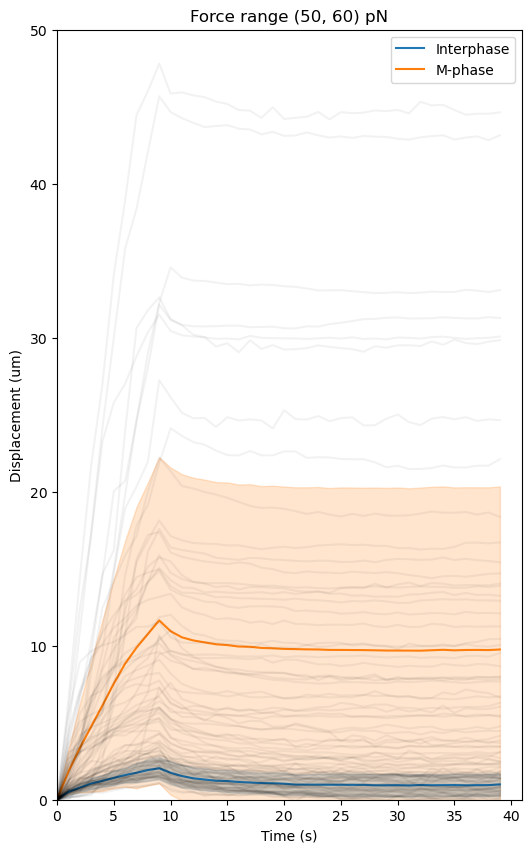

In [18]:
force_ranges = [(30, 40), (40, 50), (50, 60)]

df_all_tracks = df_all_tracks.sort_values(by=['TRACK_ID', 'NORMALIZED_TIME'], ascending=True)

for force_range in force_ranges:
    df_force_range = df_all_tracks[(df_all_tracks['AVG_FORCE']>=force_range[0])&(df_all_tracks['AVG_FORCE']<force_range[1])&(df_all_tracks['USABLE']==1)]

    plt.figure(figsize=(6, 10))
    # group data by MT status
    df_grouped_mean = df_force_range.groupby(by=['MT_STATUS', 'NORMALIZED_TIME']).mean(numeric_only=True).reset_index()
    plt.plot(df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='y', 'NORMALIZED_TIME'], df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='y', 'CORRECTED DISPLACEMENT [um]'], color=sns.color_palette()[0], label= 'Interphase')
    plt.plot(df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='n', 'NORMALIZED_TIME'], df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='n', 'CORRECTED DISPLACEMENT [um]'], color=sns.color_palette()[1], label='M-phase')

    df_grouped_std = df_force_range.groupby(by=['MT_STATUS', 'NORMALIZED_TIME']).std(numeric_only=True).reset_index()
    plt.fill_between(
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='y', 'NORMALIZED_TIME'], 
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='y', 'CORRECTED DISPLACEMENT [um]'] - df_grouped_std.loc[df_grouped_mean['MT_STATUS']=='y', 'CORRECTED DISPLACEMENT [um]'], 
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='y', 'CORRECTED DISPLACEMENT [um]'] + df_grouped_std.loc[df_grouped_mean['MT_STATUS']=='y', 'CORRECTED DISPLACEMENT [um]'],
        color=sns.color_palette()[0], alpha=0.2)
    
    plt.fill_between(
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='n', 'NORMALIZED_TIME'], 
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='n', 'CORRECTED DISPLACEMENT [um]'] - df_grouped_std.loc[df_grouped_mean['MT_STATUS']=='n', 'CORRECTED DISPLACEMENT [um]'], 
        df_grouped_mean.loc[df_grouped_mean['MT_STATUS']=='n', 'CORRECTED DISPLACEMENT [um]'] + df_grouped_std.loc[df_grouped_mean['MT_STATUS']=='n', 'CORRECTED DISPLACEMENT [um]'],
        color=sns.color_palette()[1], alpha=0.2)
    

    # same thing but with regplot :) LEFT HERE
    

    for embryo in df_force_range['EMBRYO'].unique():
        for track in df_force_range[df_force_range['EMBRYO']==embryo]['TRACK_ID'].unique():
            for pulse in df_force_range[(df_force_range['EMBRYO']==embryo)&(df_force_range['TRACK_ID']==track)]['PULSE_NUMBER'].unique():
                df = df_force_range[(df_force_range['EMBRYO']==embryo)&(df_force_range['TRACK_ID']==track)&(df_force_range['PULSE_NUMBER']==pulse)]
                df = df.sort_values(by='NORMALIZED_TIME', ascending=True)
                plt.plot(df['NORMALIZED_TIME'], df['CORRECTED DISPLACEMENT [um]'], 'k-', alpha=0.05)
    plt.xlabel('Time (s)')
    plt.ylabel('Displacement (um)')
    plt.title(f'Force range {force_range} pN')
    plt.legend()
    plt.ylim(bottom=0, top=50)
    plt.xlim(left=0)
    plt.show()

# Histograms of binned force data

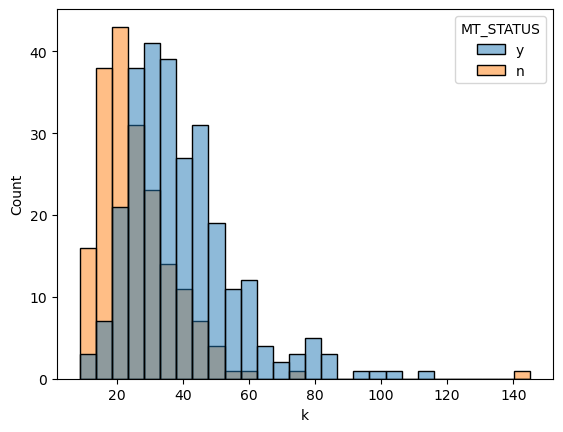

/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:16: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)
/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:26: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)


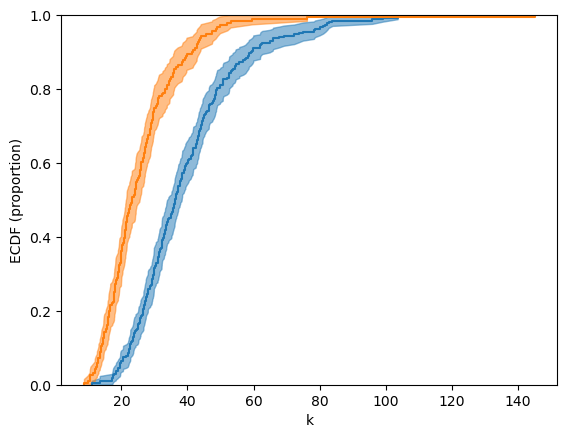

MannwhitneyuResult(statistic=np.float64(11229.0), pvalue=np.float64(5.158774004326567e-25))


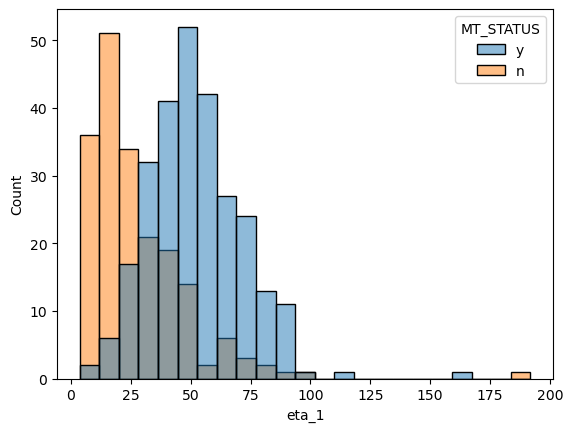

/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:16: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)
/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:26: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)


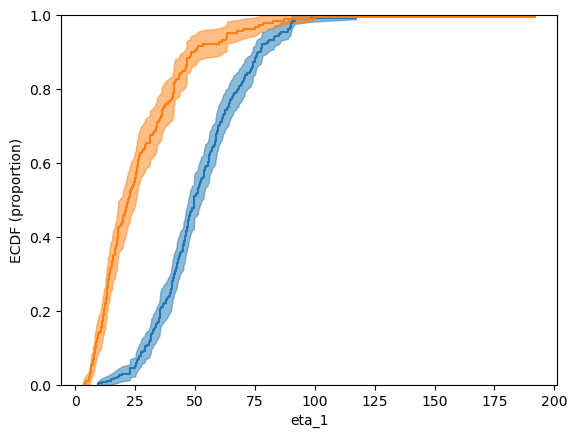

MannwhitneyuResult(statistic=np.float64(8205.0), pvalue=np.float64(1.0085020121774003e-35))


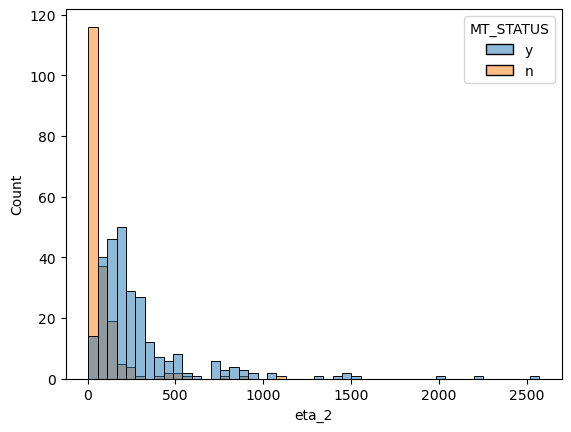

/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:16: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)
/var/folders/c1/95zwm3_14_j1wp412s49dvlr0000gp/T/ipykernel_85302/3752342758.py:26: RuntimeWarning: The confidence interval is undefined at some observations. This is a feature of the mathematical formula used, not an error in its implementation.
  ci = res.cdf.confidence_interval(confidence_level=0.95)


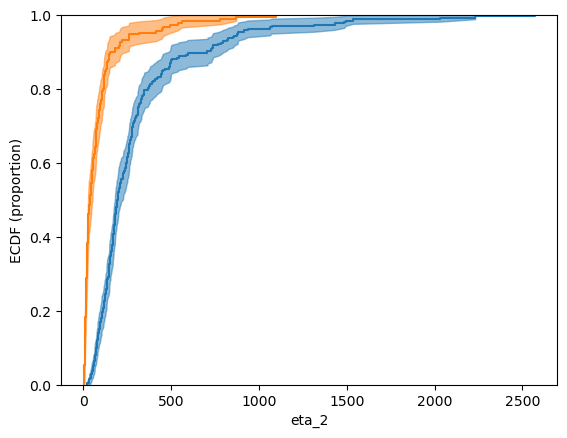

MannwhitneyuResult(statistic=np.float64(6477.0), pvalue=np.float64(9.820301114983683e-43))


In [117]:
from scipy.stats import ecdf, ttest_ind, mannwhitneyu


for param in ['k', 'eta_1', 'eta_2']:
    df_binned_force = df_results_filtered[(df_results_filtered['AVG_FORCE']>30)&(df_results_filtered['AVG_FORCE']<60)]
    sns.histplot(df_binned_force, x=param, hue='MT_STATUS')
    plt.show()

    res = ecdf(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values)
    # print(res.cdf.confidence_interval())
    ax = plt.subplot()

    # sns.ecdfplot(df_binned_force, x=param, hue='MT_STATUS')
    ecdf_data_x = df_binned_force.sort_values(by=param, ascending=True).loc[df_binned_force['MT_STATUS']=='y', param]
    sns.ecdfplot(x=res.cdf.quantiles, color=sns.color_palette()[0])
    ci = res.cdf.confidence_interval(confidence_level=0.95)
    plt.fill_between(res.cdf.quantiles, ci.low.probabilities, ci.high.probabilities, color=sns.color_palette()[0], alpha=0.5)

    res = ecdf(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values)
    # print(res.cdf.confidence_interval())
    ax = plt.subplot()

    # sns.ecdfplot(df_binned_force, x=param, hue='MT_STATUS')
    ecdf_data_x = df_binned_force.sort_values(by=param, ascending=True).loc[df_binned_force['MT_STATUS']=='n', param]
    sns.ecdfplot(x=res.cdf.quantiles, color=sns.color_palette()[1])
    ci = res.cdf.confidence_interval(confidence_level=0.95)
    plt.fill_between(res.cdf.quantiles, ci.low.probabilities, ci.high.probabilities, color=sns.color_palette()[1], alpha=0.5)


    plt.ylabel('ECDF (proportion)')
    plt.xlabel(f'{param}')
    plt.show()

    res = mannwhitneyu(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values, 
                    df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values)

    print(res)

# Confidence intervals and p values of parameters

In [130]:
rng = np.random.default_rng()

df_params_stats = pd.DataFrame()

for param in ['k', 'eta_1', 'eta_2']:
    df_binned_force = df_results_filtered[(df_results_filtered['AVG_FORCE']>30)&(df_results_filtered['AVG_FORCE']<60)]
    res_I = bootstrap((df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values, ), statistic=np.median, rng=rng)

    new_line = {'parameter': param, 
                'median': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values),
                'conf_int_low': res_I.confidence_interval[0], 
                'conf_int_high': res_I.confidence_interval[1],
                'y_err_low': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values) - res_I.confidence_interval[0],
                'y_err_high': res_I.confidence_interval[1] - np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values),
                'phase': 'Interphase',
                'MT_STATUS': 'y'
                }
    df_params_stats = pd.concat([df_params_stats, pd.DataFrame(new_line, index=[0])])


    df_binned_force = df_results_filtered[(df_results_filtered['AVG_FORCE']>30)&(df_results_filtered['AVG_FORCE']<60)]
    res_M = bootstrap((df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values, ), statistic=np.median, rng=rng)

    new_line = {'parameter': param, 
                'median': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values),
                'conf_int_low': res_M.confidence_interval[0], 
                'conf_int_high': res_M.confidence_interval[1],
                'y_err_low': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values) - res_M.confidence_interval[0],
                'y_err_high': res_M.confidence_interval[1] - np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values),
                'phase': 'M-phase',
                'MT_STATUS': 'n'
                }
    df_params_stats = pd.concat([df_params_stats, pd.DataFrame(new_line, index=[0])])

df_params_stats.head(5)

parameter      median  conf_int_low  conf_int_high  y_err_low  y_err_high  \
0         k   36.247476     33.993034      38.254231   2.254442    2.006756   
0         k   23.125523     21.477923      25.610123   1.647600    2.484600   
0     eta_1   49.624559     47.239820      53.041707   2.384740    3.417148   
0     eta_1   21.944043     19.094546      25.345455   2.849497    3.401412   
0     eta_2  195.704121    180.754280     226.480959  14.949841   30.776838   

        phase MT_STATUS  
0  Interphase         y  
0     M-phase         n  
0  Interphase         y  
0     M-phase         n  
0  Interphase         y

0.05567024259307769
0.0007698187754988271
0.000465617121503073


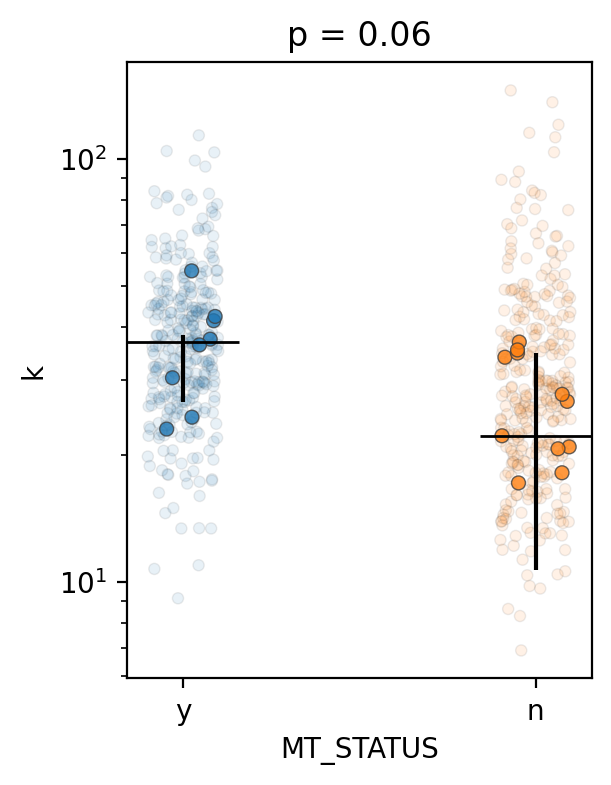

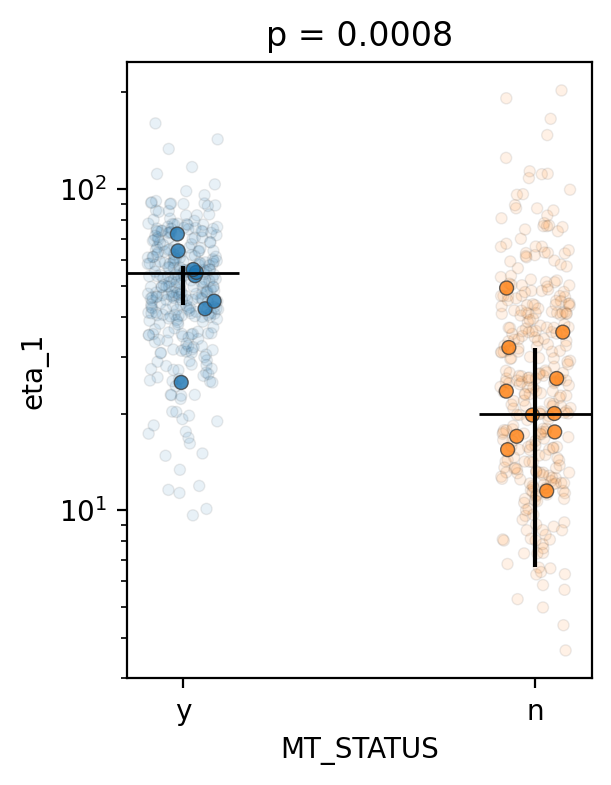

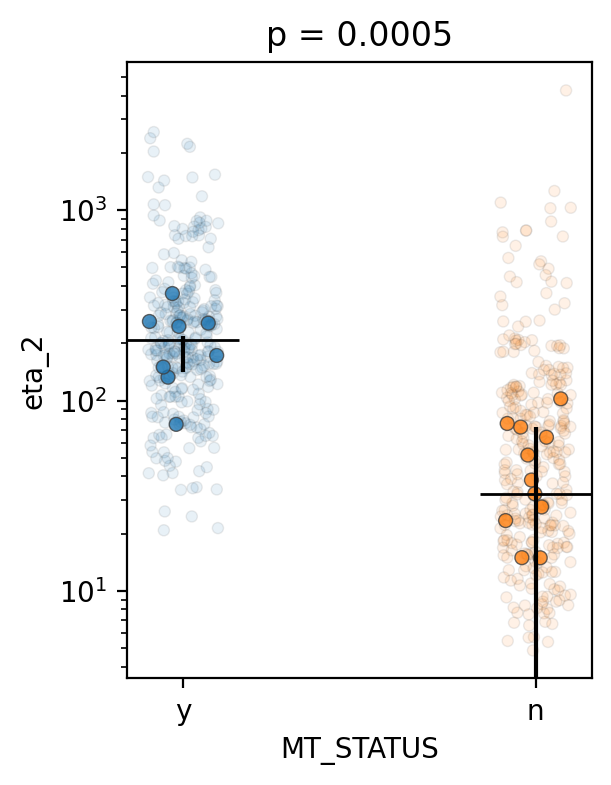

In [157]:
df_data_stats = df_results_filtered.groupby(['EMBRYO', 'MT_STATUS']).median(numeric_only=True).reset_index()

rng = np.random.default_rng()

df_params_stats = pd.DataFrame()

p_values = []

for param in ['k', 'eta_1', 'eta_2']:
    df_binned_force = df_data_stats[(df_data_stats['AVG_FORCE']>30)&(df_data_stats['AVG_FORCE']<60)]
    res_I = bootstrap((df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values, ), statistic=np.median, rng=rng)

    new_line = {'parameter': param, 
                'median': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values),
                'conf_int_low': res_I.confidence_interval[0], 
                'conf_int_high': res_I.confidence_interval[1],
                'y_err_low': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values) - res_I.confidence_interval[0],
                'y_err_high': res_I.confidence_interval[1] - np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values),
                'phase': 'Interphase',
                'MT_STATUS': 'y'
                }
    df_params_stats = pd.concat([df_params_stats, pd.DataFrame(new_line, index=[0])])


    df_binned_force = df_data_stats[(df_data_stats['AVG_FORCE']>30)&(df_data_stats['AVG_FORCE']<60)]
    res_M = bootstrap((df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values, ), statistic=np.median, rng=rng)

    new_line = {'parameter': param, 
                'median': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values),
                'conf_int_low': res_M.confidence_interval[0], 
                'conf_int_high': res_M.confidence_interval[1],
                'y_err_low': np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values) - res_M.confidence_interval[0],
                'y_err_high': res_M.confidence_interval[1] - np.median(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values),
                'phase': 'M-phase',
                'MT_STATUS': 'n'
                }
    df_params_stats = pd.concat([df_params_stats, pd.DataFrame(new_line, index=[0])])

    res = ttest_ind(df_binned_force.loc[df_binned_force['MT_STATUS']=='n', param].values, 
                    df_binned_force.loc[df_binned_force['MT_STATUS']=='y', param].values, equal_var=False)
    print(res.pvalue)
    p_values.append(res.pvalue)

df_params_stats.head(5)



for (param, p_value) in zip(['k', 'eta_1', 'eta_2'], p_values):
    fig = plt.figure(figsize=(3, 4), dpi=200)
    sns.stripplot(x='MT_STATUS', y=param, hue='MT_STATUS', data=df_results_filtered, jitter=True, alpha=0.1, linewidth=0.5, legend=False, size=4, zorder=0)
    sns.stripplot(x='MT_STATUS', y=param, hue='MT_STATUS', data=df_data_stats, jitter=True, alpha=0.8, linewidth=0.5, legend=False, size=5, zorder=1)

    plt.errorbar(df_params_stats.loc[df_params_stats['parameter']==param, 'MT_STATUS'], df_params_stats.loc[df_params_stats['parameter']==param, 'median'], yerr=df_params_stats.loc[df_params_stats['parameter']==param, ['y_err_low', 'y_err_high']], marker = '_', markersize=40,  color='k', linestyle='', zorder=2)
    plt.title(f'p = {p_value:.1g}')
    plt.yscale('log')
    plt.show()
